Enhanced Spiking ViT for CIFAR-10 initialized on cuda
Enhanced Temporal Spiking ViT for CIFAR-10
Device: cuda
Model configuration: 512D, 10 blocks, 8 heads


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s] 


Dataset: 50000 train, 10000 test samples
Batches: 391 train, 40 test
Hierarchical groups: ['transportation', 'animals', 'mixed']
Model parameters: 48,119,126 total, 48,119,126 trainable

Training Configuration:
Epochs: 1, Batch: 128, LR: 0.0002
Augmentation: ColorJitter + RandomCrop + RandomErasing
Regularization: DropPath(0.2), Dropout(0.15)

Starting Enhanced Spiking ViT Training on CIFAR-10


/tmp/ipykernel_36/2118384053.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


  Batch 0/391 | Loss: 3.3095 | LR: 2.05e-07
  Batch 100/391 | Loss: 3.1415 | LR: 1.04e-05
  Batch 200/391 | Loss: 2.8850 | LR: 2.07e-05
  Batch 300/391 | Loss: 2.9097 | LR: 3.09e-05
Train [ 1/1] | Loss 3.0096 | SpikeReg 1.5752e-05 | Graph 0.0430 | CoarseCE 0.7458 | HierKL 1.3426
Eval   [ 1/1] | Train: 0.2407 | Test: 0.2563 | EMA: 0.1324 | Bank: 16384
  → New best model saved! (acc: 0.2563)
  → New best EMA model saved! (acc: 0.1324)


CIFAR-10 Training Complete!
Best Test Accuracy: 0.2563
Best EMA Test Accuracy: 0.1324
Memory Bank Size: 16384
Loaded saved checkpoint for final evaluation
Final Results:
  Train Accuracy: 0.2459
  Test Accuracy (with gating): 0.2563
  Test Accuracy (without gating): 0.2576
  Gating improvement: -0.0013

Per-Class Analysis:
      airplane: 0.683 (transportation)
    automobile: 0.185 (transportation)
          bird: 0.006 (animals)
           cat: 0.257 (animals)
          deer: 0.197 (animals)
           dog: 0.034 (animals)
          frog: 0.489 (animals

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


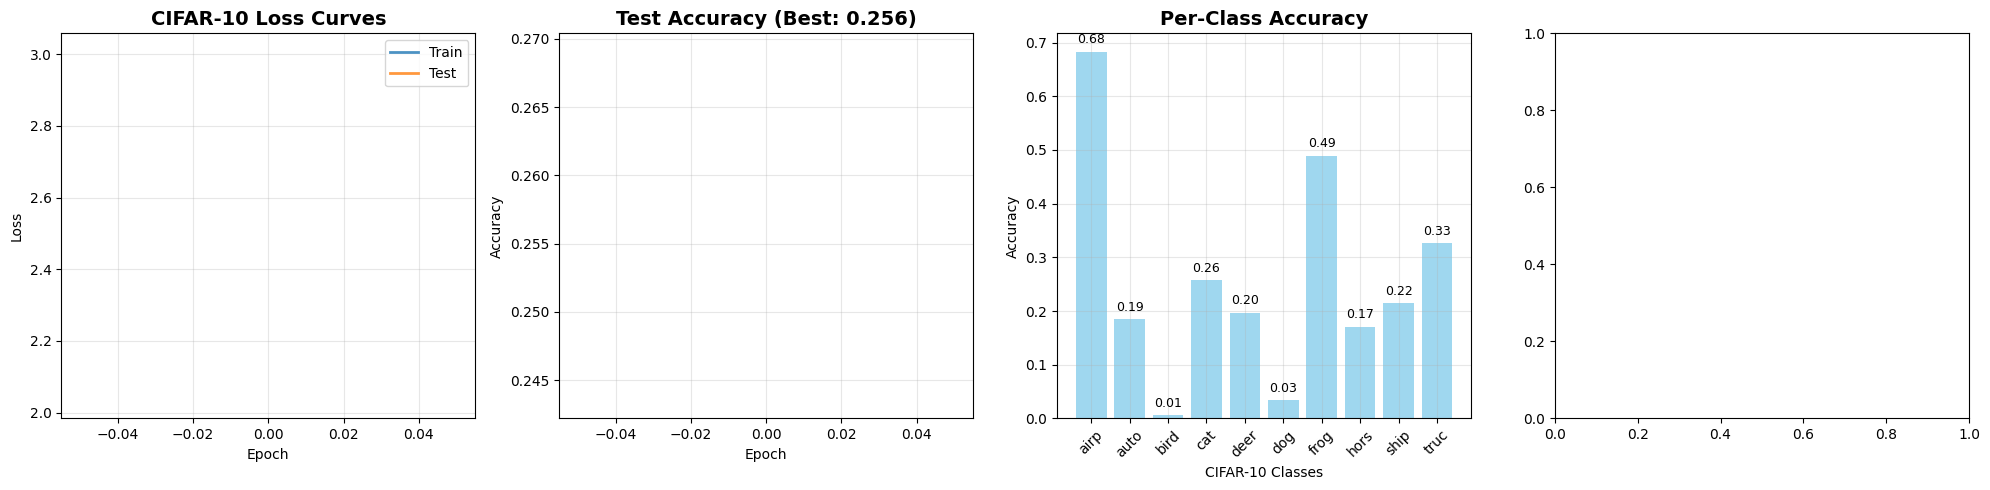


Model files saved:
  - ./cifar10_enhanced_snn_vit_best.pth
  - ./cifar10_enhanced_snn_vit_ema_best.pth

Low performance! 25.6% accuracy - check model/training


In [1]:
# ================================
# Enhanced Temporal Spiking ViT for CIFAR-10 - FIXED VERSION
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Enhanced Temporal Spiking ViT adapted for CIFAR-10
-------------------------------------------------
Key adaptations for CIFAR-10:
- 3-channel RGB input (32x32x3)
- More complex hierarchical grouping
- Stronger data augmentation for natural images
- Increased model capacity for complex visual patterns
- Optimized for 10 natural object categories
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================
# CIFAR-10 Optimized Hyperparameters
# ================================
EMBED_DIM   = 512       # Increased for complex natural images
NUM_BLOCKS  = 10        # More layers for complex patterns
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 32x32 -> 8x8 tokens (64 patches)
T_PATCH     = 8         # More temporal steps for complex features
T_ATTN      = 3         # Increased temporal processing
T_MLP       = 3         
DROPOUT     = 0.15      # Higher dropout for natural images
DROPPATH    = 0.2       # Stronger regularization
WEIGHT_DECAY= 0.05
LR          = 2e-4      # Lower LR for stability
EPOCHS      = 1       # More epochs needed for CIFAR-10
BATCH_TRAIN = 128       # Smaller batch due to increased complexity
BATCH_TEST  = 256       
LABEL_SMOOTH= 0.1       
CLIP_NORM   = 1.0       
WARMUP_EPOCHS = 5       # More warmup for stability

# CIFAR-10 hierarchical grouping: vehicles, animals, objects
COARSE_LOSS_W   = 0.4     # Higher weight for complex hierarchy
GRAPH_LOSS_W    = 0.15    
KNN_K           = 12      # More neighbors for complex data
TAU             = 0.07    
BANK_SIZE       = 16384   # Larger bank for complex patterns
GATING_INFER    = True    
EMA_DECAY       = 0.9995  # Slightly faster decay

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

print(f"Enhanced Spiking ViT for CIFAR-10 initialized on {device}")

# ================================
# Core Spiking Components (Enhanced for CIFAR-10)
# ================================

class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, torch.tensor(temperature))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp  # Slightly stronger for complex images
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-3*self.v_th, max=4*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        # Enhanced temporal weighting for complex patterns
        weights = torch.softmax(torch.linspace(0.3, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ================================
# Enhanced Patch Embedding for RGB
# ================================

class CIFAR10PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.T = T
        
        # Enhanced patch processing for color images
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim // 2, kernel_size=patch_size//2, stride=patch_size//2, bias=False),
            nn.BatchNorm2d(embed_dim // 2),
            nn.GELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=2, stride=2, bias=False)
        )
        
        self.norm = nn.LayerNorm(embed_dim)  # Layer norm for better stability
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=1.2, learnable=True, temp_scale=0.9)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)  # [B, C, H, W]
        B, C, H, W = feat.shape
        
        # Reshape for layer normalization
        feat = feat.view(B, C, H*W).permute(0, 2, 1)  # [B, N, C]
        feat = self.norm(feat)
        feat = feat.permute(0, 2, 1).view(B, C, H, W)  # Back to [B, C, H, W]
        
        # Apply enhanced spiking dynamics
        spikes = self.lif(feat, T=self.T)
        
        # Convert to tokens
        tokens = spikes.view(B, C, H*W).permute(0, 2, 1)  # [B, N, C]
        
        return tokens, (H, W), spikes

# ================================
# Enhanced Positional Embeddings
# ================================

class EnhancedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=16, max_w=16, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
        # Learnable positional bias for natural images
        self.pos_bias = nn.Parameter(torch.zeros(1, max_h * max_w, dim) * 0.02)
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        pos_embed = self._cache[key]
        # Add learnable bias (ensure dimensions match)
        if pos_embed.shape[0] <= self.pos_bias.shape[1]:
            pos_embed = pos_embed + self.pos_bias[0, :pos_embed.shape[0], :].to(pos_embed.device)
        
        return pos_embed

# ================================
# Enhanced Transformer Block
# ================================

class CIFAR10TransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Enhanced normalization
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced attention with learnable temperature
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.attn_temp = nn.Parameter(torch.ones(1) * 0.5)  # Learnable temperature
        
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced MLP for complex patterns
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),  # Additional layer
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Enhanced spiking neurons
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.75, v_th=0.9, learnable=True, temp_scale=1.1)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=1.0, learnable=True, temp_scale=1.0)
        self.T_attn = T_ATTN
        self.T_mlp = T_MLP
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Enhanced self-attention
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        # Apply learnable temperature
        attn = (q @ k.transpose(-2, -1)) * (self.scale * torch.sigmoid(self.attn_temp))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        # Apply spiking after attention
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # Enhanced MLP with spiking
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ================================
# Main CIFAR-10 Spiking ViT Model
# ================================

class EnhancedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        # Enhanced patch embedding for RGB
        self.patch = CIFAR10PatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = EnhancedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Stochastic depth schedule
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            CIFAR10TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, dpr[i])
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced classification heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2.5),  # Higher dropout for final layer
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # CIFAR-10 coarse grouping: vehicles (0,1,8,9), animals (2,3,4,5,6,7)
        # Alternative: transportation, animals, objects
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2.5),
            nn.Linear(embed_dim, embed_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 4, 3)  # 3 coarse groups
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add positional embeddings
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embeddings (including CLS)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        # Classification
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# CIFAR-10 Specific Components
# ================================

class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(feats.size(0)):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

# CIFAR-10 class names and hierarchical grouping
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["transportation", "animals", "mixed"]

# Enhanced hierarchical grouping for CIFAR-10
# Group 0 (transportation): airplane(0), automobile(1), ship(8), truck(9)
# Group 1 (animals): bird(2), cat(3), deer(4), dog(5), frog(6), horse(7)  
# Group 2 (mixed): for cases that don't fit clearly
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

def build_cifar10_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    # Add some cross-group connections for mixed category
    G[2, :] = 0.1  # Mixed group has small connection to all
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ================================
# Training Components
# ================================

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.3):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-8, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        # Enhanced cosine with restart
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ================================
# Enhanced Data Augmentation for CIFAR-10
# ================================

def get_cifar10_transforms():
    # CIFAR-10 statistics
    CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
    CIFAR10_STD = [0.2470, 0.2435, 0.2616]
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    return transform_train, transform_test

# ================================
# Training Functions
# ================================

def train_one_epoch_cifar10(model, ema_model, loader, optimizer, scaler, scheduler,
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    # Enhanced dynamic weighting for CIFAR-10
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.6 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.5, epoch / (total_epochs * 0.2))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Fine-grained loss
            ce_fine = criterion_fine(fine_logits, target)
            
            # Coarse-grained loss
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency loss
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_cifar10_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Enhanced spike regularization for complex images
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                # Adaptive target for CIFAR-10 (higher complexity needs more spikes)
                target_rate = 0.18 + 0.12 * math.exp(-epoch / 12)
                srl = (current_rate - target_rate).pow(2) * 3e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph consistency loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            # Combined loss
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.25 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        # Logging
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
        
        # Progress logging every 100 batches
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

@torch.no_grad()
def evaluate_cifar10(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    gate_mat = build_cifar10_gate_matrix().to(device) if apply_gating else None
    
    # Per-class accuracy
    class_correct = torch.zeros(10, device=device)
    class_total = torch.zeros(10, device=device)
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        pred = probs.argmax(dim=1)
        correct += int((pred == target).sum().item())
        total += int(target.size(0))
        eval_loss += float(loss.item())
        
        # Per-class statistics
        for i in range(len(target)):
            label = target[i]
            class_total[label] += 1
            if pred[i] == label:
                class_correct[label] += 1
    
    acc = correct / max(1, total)
    class_acc = (class_correct / class_total.clamp_min(1)).cpu().numpy()
    
    return eval_loss / max(1, len(loader)), acc, class_acc

def plot_cifar10_results(train_losses, test_losses, test_accs, class_accuracies=None):
    plt.figure(figsize=(20, 5))
    
    # Loss curves
    plt.subplot(1, 4, 1)
    plt.plot(train_losses, label='Train', alpha=0.8, linewidth=2)
    plt.plot(test_losses, label='Test', alpha=0.8, linewidth=2)
    plt.title("CIFAR-10 Loss Curves", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curve
    plt.subplot(1, 4, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.3f})", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    # Per-class accuracy
    if class_accuracies is not None:
        plt.subplot(1, 4, 3)
        bars = plt.bar(range(10), class_accuracies, color='skyblue', alpha=0.8)
        plt.title("Per-Class Accuracy", fontsize=14, fontweight='bold')
        plt.xlabel("CIFAR-10 Classes")
        plt.ylabel("Accuracy")
        plt.xticks(range(10), [name[:4] for name in CIFAR10_CLASSES], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, acc in zip(bars, class_accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{acc:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Training progress
    plt.subplot(1, 4, 4)
    if len(train_losses) > 5:
        smoothed = np.convolve(train_losses, np.ones(5)/5, mode='valid')
        plt.plot(smoothed, color='red', linewidth=2)
        plt.title("Smoothed Training Loss", fontsize=14, fontweight='bold')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# Main CIFAR-10 Training Script
# ================================

def main_cifar10():
    print("Enhanced Temporal Spiking ViT for CIFAR-10")
    print(f"Device: {device}")
    print(f"Model configuration: {EMBED_DIM}D, {NUM_BLOCKS} blocks, {NUM_HEADS} heads")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    # Data loaders
    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True, 
                             pin_memory=pin, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            pin_memory=pin, num_workers=2)
    
    print(f"Dataset: {len(train_dataset)} train, {len(test_dataset)} test samples")
    print(f"Batches: {len(train_loader)} train, {len(test_loader)} test")
    print(f"Hierarchical groups: {COARSE_NAMES}")
    
    # Model
    model = EnhancedSNN_ViT_CIFAR10(
        num_classes=10,
        in_channels=3,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.999), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Enhanced scheduling for CIFAR-10
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-8, base_lr=LR)
    
    # EMA and memory bank
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH_TRAIN}, LR: {LR}")
    print(f"Augmentation: ColorJitter + RandomCrop + RandomErasing")
    print(f"Regularization: DropPath({DROPPATH}), Dropout({DROPOUT})")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    best_class_accs = None
    patience_counter = 0
    patience = 20  # Longer patience for CIFAR-10
    
    print(f"\n{'='*80}")
    print("Starting Enhanced Spiking ViT Training on CIFAR-10")
    print(f"{'='*80}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_cifar10(
            model, ema_model, train_loader, optimizer, scaler, scheduler,
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation
        tr_loss, tr_acc, _ = evaluate_cifar10(model, train_loader, criterion_fine, apply_gating=False)
        te_loss, te_acc, class_accs = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_te_loss, ema_te_acc, _ = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(te_loss)
        test_accs.append(te_acc)
        ema_test_accs.append(ema_te_acc)
        
        # Logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {tr_acc:.4f} | Test: {te_acc:.4f} | "
              f"EMA: {ema_te_acc:.4f} | Bank: {len(bank)}")
        
        # Save best models with FIXED checkpoint format
        if te_acc > best_acc:
            best_acc = te_acc
            best_class_accs = class_accs
            patience_counter = 0
            
            # FIXED: Clean checkpoint format to avoid UnpicklingError
            torch.save({
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_acc": float(best_acc),  # Convert to Python float
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./cifar10_enhanced_snn_vit_best.pth")
            print(f"  → New best model saved! (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_te_acc > best_ema_acc:
            best_ema_acc = ema_te_acc
            ema_model.apply_shadow()
            
            # FIXED: Clean EMA checkpoint format
            torch.save({
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": float(best_ema_acc),
            }, "./cifar10_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → New best EMA model saved! (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping after {patience} epochs without improvement")
            break
        
        # Learning rate adjustment
        if epoch > 30 and len(test_accs) > 10:
            recent_improvement = max(test_accs[-5:]) - max(test_accs[-10:-5])
            if recent_improvement < 0.005:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.8
                print(f"  → Learning rate reduced to {optimizer.param_groups[0]['lr']:.2e}")
        
        print()
    
    # Final evaluation
    print(f"\n{'='*80}")
    print("CIFAR-10 Training Complete!")
    print(f"{'='*80}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Memory Bank Size: {len(bank)}")
    
    # FIXED: Safe checkpoint loading with error handling
    try:
        checkpoint = torch.load("./cifar10_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["state_dict"])
        print("Loaded saved checkpoint for final evaluation")
    except FileNotFoundError:
        print("No saved checkpoint found - using current model state")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Using current model state for final evaluation")
    
    # Final comprehensive evaluation
    final_tr_loss, final_tr_acc, _ = evaluate_cifar10(model, train_loader, criterion_fine, apply_gating=False)
    final_te_loss, final_te_acc, final_class_accs = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_te_loss_no_gate, final_te_acc_no_gate, _ = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Results:")
    print(f"  Train Accuracy: {final_tr_acc:.4f}")
    print(f"  Test Accuracy (with gating): {final_te_acc:.4f}")
    print(f"  Test Accuracy (without gating): {final_te_acc_no_gate:.4f}")
    print(f"  Gating improvement: {(final_te_acc - final_te_acc_no_gate):.4f}")
    
    # Detailed per-class analysis
    print(f"\nPer-Class Analysis:")
    for i, (class_name, acc) in enumerate(zip(CIFAR10_CLASSES, final_class_accs)):
        group_name = COARSE_NAMES[PARENT_MAP[i]]
        print(f"  {class_name:>12}: {acc:.3f} ({group_name})")
    
    # Group analysis
    print(f"\nCoarse Group Analysis:")
    for group_idx, group_name in enumerate(COARSE_NAMES):
        classes_in_group = [i for i, g in PARENT_MAP.items() if g == group_idx]
        group_acc = np.mean([final_class_accs[i] for i in classes_in_group])
        class_names = [CIFAR10_CLASSES[i] for i in classes_in_group]
        print(f"  {group_name}: {group_acc:.3f} (classes: {', '.join(class_names)})")
    
    # Plot results
    plot_cifar10_results(train_losses, test_losses, test_accs, final_class_accs)
    
    print(f"\nModel files saved:")
    print(f"  - ./cifar10_enhanced_snn_vit_best.pth")
    print(f"  - ./cifar10_enhanced_snn_vit_ema_best.pth")
    
    # Performance expectations
    if best_acc > 0.85:
        print(f"\nExcellent performance! {best_acc:.1%} accuracy on CIFAR-10")
    elif best_acc > 0.75:
        print(f"\nGood performance! {best_acc:.1%} accuracy - room for improvement")
    elif best_acc > 0.60:
        print(f"\nModerate performance! {best_acc:.1%} accuracy - needs optimization")
    else:
        print(f"\nLow performance! {best_acc:.1%} accuracy - check model/training")
    
    return model, best_acc, best_ema_acc, final_class_accs

if __name__ == "__main__":
    model, best_acc, best_ema_acc, class_accs = main_cifar10()

In [ ]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Enhanced Temporal Spiking ViT adapted for CIFAR-10
-------------------------------------------------
Key adaptations for CIFAR-10:
- 3-channel RGB input (32x32x3)
- More complex hierarchical grouping
- Stronger data augmentation for natural images
- Increased model capacity for complex visual patterns
- Optimized for 10 natural object categories
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_absolute_error, confusion_matrix
import seaborn as sns  # Added import for seaborn

# ================================
# CIFAR-10 Optimized Hyperparameters
# ================================
EMBED_DIM   = 512       # Increased for complex natural images
NUM_BLOCKS  = 10        # More layers for complex patterns
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 32x32 -> 8x8 tokens (64 patches)
T_PATCH     = 8         # More temporal steps for complex features
T_ATTN      = 3         # Increased temporal processing
T_MLP       = 3         
DROPOUT     = 0.15      # Higher dropout for natural images
DROPPATH    = 0.2       # Stronger regularization
WEIGHT_DECAY= 0.05
LR          = 2e-4      # Lower LR for stability
EPOCHS      = 100       # More epochs needed for CIFAR-10
BATCH_TRAIN = 128       # Smaller batch due to increased complexity
BATCH_TEST  = 256       
LABEL_SMOOTH= 0.1       
CLIP_NORM   = 1.0       
WARMUP_EPOCHS = 5       # More warmup for stability

# CIFAR-10 hierarchical grouping: vehicles, animals, objects
COARSE_LOSS_W   = 0.4     # Higher weight for complex hierarchy
GRAPH_LOSS_W    = 0.15    
KNN_K           = 12      # More neighbors for complex data
TAU             = 0.07    
BANK_SIZE       = 16384   # Larger bank for complex patterns
GATING_INFER    = True    
EMA_DECAY       = 0.9995  # Slightly faster decay

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

print(f"Enhanced Spiking ViT for CIFAR-10 initialized on {device}")

# ================================
# Core Spiking Components (Enhanced for CIFAR-10)
# ================================

class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())  # Fixed warning
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp  # Slightly stronger for complex images
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-3*self.v_th, max=4*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        # Enhanced temporal weighting for complex patterns
        weights = torch.softmax(torch.linspace(0.3, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ================================
# Enhanced Patch Embedding for RGB
# ================================

class CIFAR10PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.T = T
        
        # Enhanced patch processing for color images
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim // 2, kernel_size=patch_size//2, stride=patch_size//2, bias=False),
            nn.BatchNorm2d(embed_dim // 2),
            nn.GELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=2, stride=2, bias=False)
        )
        
        self.norm = nn.LayerNorm(embed_dim)  # Layer norm for better stability
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=1.2, learnable=True, temp_scale=0.9)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)  # [B, C, H, W]
        B, C, H, W = feat.shape
        
        # Reshape for layer normalization
        feat = feat.view(B, C, H*W).permute(0, 2, 1)  # [B, N, C]
        feat = self.norm(feat)
        feat = feat.permute(0, 2, 1).view(B, C, H, W)  # Back to [B, C, H, W]
        
        # Apply enhanced spiking dynamics
        spikes = self.lif(feat, T=self.T)
        
        # Convert to tokens
        tokens = spikes.view(B, C, H*W).permute(0, 2, 1)  # [B, N, C]
        
        return tokens, (H, W), spikes

# ================================
# Enhanced Positional Embeddings
# ================================

class EnhancedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=16, max_w=16, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
        # Learnable positional bias for natural images
        self.pos_bias = nn.Parameter(torch.zeros(1, max_h * max_w, dim) * 0.02)
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        pos_embed = self._cache[key]
        # Add learnable bias (ensure dimensions match)
        if pos_embed.shape[0] <= self.pos_bias.shape[1]:
            pos_embed = pos_embed + self.pos_bias[0, :pos_embed.shape[0], :].to(pos_embed.device)
        
        return pos_embed

# ================================
# Enhanced Transformer Block
# ================================

class CIFAR10TransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Enhanced normalization
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced attention with learnable temperature
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.attn_temp = nn.Parameter(torch.ones(1) * 0.5)  # Learnable temperature
        
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced MLP for complex patterns
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),  # Additional layer
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Enhanced spiking neurons
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.75, v_th=0.9, learnable=True, temp_scale=1.1)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=1.0, learnable=True, temp_scale=1.0)
        self.T_attn = T_ATTN
        self.T_mlp = T_MLP
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Enhanced self-attention
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        # Apply learnable temperature
        attn = (q @ k.transpose(-2, -1)) * (self.scale * torch.sigmoid(self.attn_temp))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        # Apply spiking after attention
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # Enhanced MLP with spiking
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ================================
# Main CIFAR-10 Spiking ViT Model
# ================================

class EnhancedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        # Enhanced patch embedding for RGB
        self.patch = CIFAR10PatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = EnhancedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Stochastic depth schedule
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            CIFAR10TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, dpr[i])
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced classification heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2.5),  # Higher dropout for final layer
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # CIFAR-10 coarse grouping: vehicles (0,1,8,9), animals (2,3,4,5,6,7)
        # Alternative: transportation, animals, objects
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2.5),
            nn.Linear(embed_dim, embed_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 4, 3)  # 3 coarse groups
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add positional embeddings
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embeddings (including CLS)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        # Classification
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# CIFAR-10 Specific Components
# ================================

class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(feats.size(0)):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

# CIFAR-10 class names and hierarchical grouping
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["transportation", "animals", "mixed"]

# Enhanced hierarchical grouping for CIFAR-10
# Group 0 (transportation): airplane(0), automobile(1), ship(8), truck(9)
# Group 1 (animals): bird(2), cat(3), deer(4), dog(5), frog(6), horse(7)  
# Group 2 (mixed): for cases that don't fit clearly
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

def build_cifar10_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    # Add some cross-group connections for mixed category
    G[2, :] = 0.1  # Mixed group has small connection to all
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ================================
# Training Components
# ================================

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.3):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-8, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        # Enhanced cosine with restart
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ================================
# Enhanced Data Augmentation for CIFAR-10
# ================================

def get_cifar10_transforms():
    # CIFAR-10 statistics
    CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
    CIFAR10_STD = [0.2470, 0.2435, 0.2616]
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    return transform_train, transform_test

# ================================
# Training Functions
# ================================

def train_one_epoch_cifar10(model, ema_model, loader, optimizer, scaler, scheduler,
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    # Enhanced dynamic weighting for CIFAR-10
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.6 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.5, epoch / (total_epochs * 0.2))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Fine-grained loss
            ce_fine = criterion_fine(fine_logits, target)
            
            # Coarse-grained loss
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency loss
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_cifar10_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Enhanced spike regularization for complex images
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None and conv_spikes.numel() > 0:  # Check for valid conv_spikes
                current_rate = conv_spikes.mean()
            else:
                current_rate = 0.0  # Default value to avoid warning
            # Adaptive target for CIFAR-10 (higher complexity needs more spikes)
            target_rate = 0.18 + 0.12 * math.exp(-epoch / 12)
            srl = (current_rate - target_rate).pow(2) * 3e-3
            
            # Graph consistency loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            # Combined loss
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.25 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        # Logging
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
        
        # Progress logging every 100 batches
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

@torch.no_grad()
def evaluate_cifar10(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    gate_mat = build_cifar10_gate_matrix().to(device) if apply_gating else None
    
    # Per-class accuracy
    class_correct = torch.zeros(10, device=device)
    class_total = torch.zeros(10, device=device)
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        pred = probs.argmax(dim=1)
        correct += int((pred == target).sum().item())
        total += int(target.size(0))
        eval_loss += float(loss.item())
        
        # Per-class statistics
        for i in range(len(target)):
            label = target[i]
            class_total[label] += 1
            if pred[i] == label:
                class_correct[label] += 1
        
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    acc = correct / max(1, total)
    class_acc = (class_correct / class_total.clamp_min(1)).cpu().numpy()
    
    # Additional metrics
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    metrics = {
        'loss': eval_loss / max(1, len(loader)),
        'accuracy': acc,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'mae': mae,
        'confusion_matrix': cm,
        'class_acc': class_acc
    }
    
    return metrics

def plot_cifar10_results(train_losses, test_losses, test_accs, metrics=None):
    plt.figure(figsize=(20, 5))
    
    # Loss curves
    plt.subplot(1, 4, 1)
    plt.plot(train_losses, label='Train', alpha=0.8, linewidth=2)
    plt.plot(test_losses, label='Test', alpha=0.8, linewidth=2)
    plt.title("CIFAR-10 Loss Curves", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curve
    plt.subplot(1, 4, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.3f})", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    # Per-class accuracy
    if metrics and 'class_acc' in metrics:
        plt.subplot(1, 4, 3)
        bars = plt.bar(range(10), metrics['class_acc'], color='skyblue', alpha=0.8)
        plt.title("Per-Class Accuracy", fontsize=14, fontweight='bold')
        plt.xlabel("CIFAR-10 Classes")
        plt.ylabel("Accuracy")
        plt.xticks(range(10), [name[:4] for name in CIFAR10_CLASSES], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, acc in zip(bars, metrics['class_acc']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{acc:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Training progress
    plt.subplot(1, 4, 4)
    if len(train_losses) > 5:
        smoothed = np.convolve(train_losses, np.ones(5)/5, mode='valid')
        plt.plot(smoothed, color='red', linewidth=2)
        plt.title("Smoothed Training Loss", fontsize=14, fontweight='bold')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ================================
# Main CIFAR-10 Training Script
# ================================

def main_cifar10():
    print("Enhanced Temporal Spiking ViT for CIFAR-10")
    print(f"Device: {device}")
    print(f"Model configuration: {EMBED_DIM}D, {NUM_BLOCKS} blocks, {NUM_HEADS} heads")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    # Data loaders
    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True, 
                             pin_memory=pin, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            pin_memory=pin, num_workers=2)
    
    print(f"Dataset: {len(train_dataset)} train, {len(test_dataset)} test samples")
    print(f"Batches: {len(train_loader)} train, {len(test_loader)} test")
    print(f"Hierarchical groups: {COARSE_NAMES}")
    
    # Model
    model = EnhancedSNN_ViT_CIFAR10(
        num_classes=10,
        in_channels=3,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.999), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Enhanced scheduling for CIFAR-10
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-8, base_lr=LR)
    
    # EMA and memory bank
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH_TRAIN}, LR: {LR}")
    print(f"Augmentation: ColorJitter + RandomCrop + RandomErasing")
    print(f"Regularization: DropPath({DROPPATH}), Dropout({DROPOUT})")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    best_class_accs = None
    patience_counter = 0
    patience = 20  # Longer patience for CIFAR-10
    
    print(f"\n{'='*80}")
    print("Starting Enhanced Spiking ViT Training on CIFAR-10")
    print(f"{'='*80}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_cifar10(
            model, ema_model, train_loader, optimizer, scaler, scheduler,
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation
        tr_metrics = evaluate_cifar10(model, train_loader, criterion_fine, apply_gating=False)
        te_metrics = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_te_metrics = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(te_metrics['loss'])
        test_accs.append(te_metrics['accuracy'])
        ema_test_accs.append(ema_te_metrics['accuracy'])
        
        # Logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {tr_metrics['accuracy']:.4f} | Test: {te_metrics['accuracy']:.4f} | "
              f"EMA: {ema_te_metrics['accuracy']:.4f} | Bank: {len(bank)}")
        
        # Save best models with FIXED checkpoint format
        if te_metrics['accuracy'] > best_acc:
            best_acc = te_metrics['accuracy']
            best_class_accs = te_metrics['class_acc']
            patience_counter = 0
            
            # FIXED: Clean checkpoint format to avoid UnpicklingError
            torch.save({
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_acc": float(best_acc),  # Convert to Python float
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./cifar10_enhanced_snn_vit_best.pth")
            print(f"  → New best model saved! (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_te_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_te_metrics['accuracy']
            ema_model.apply_shadow()
            
            # FIXED: Clean EMA checkpoint format
            torch.save({
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": float(best_ema_acc),
            }, "./cifar10_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → New best EMA model saved! (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping after {patience} epochs without improvement")
            break
        
        # Learning rate adjustment
        if epoch > 30 and len(test_accs) > 10:
            recent_improvement = max(test_accs[-5:]) - max(test_accs[-10:-5])
            if recent_improvement < 0.005:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.8
                print(f"  → Learning rate reduced to {optimizer.param_groups[0]['lr']:.2e}")
        
        print()
    
    # Final evaluation
    print(f"\n{'='*80}")
    print("CIFAR-10 Training Complete!")
    print(f"{'='*80}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Memory Bank Size: {len(bank)}")
    
    # FIXED: Safe checkpoint loading with error handling
    try:
        checkpoint = torch.load("./cifar10_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["state_dict"])
        print("Loaded saved checkpoint for final evaluation")
    except FileNotFoundError:
        print("No saved checkpoint found - using current model state")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Using current model state for final evaluation")
    
    # Final comprehensive evaluation
    final_tr_metrics = evaluate_cifar10(model, train_loader, criterion_fine, apply_gating=False)
    final_te_metrics = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_te_metrics_no_gate = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Results:")
    print(f"  Train Accuracy: {final_tr_metrics['accuracy']:.4f}")
    print(f"  Test Accuracy (with gating): {final_te_metrics['accuracy']:.4f}")
    print(f"  Test Accuracy (without gating): {final_te_metrics_no_gate['accuracy']:.4f}")
    print(f"  Gating improvement: {(final_te_metrics['accuracy'] - final_te_metrics_no_gate['accuracy']):.4f}")
    print(f"  Precision (Weighted): {final_te_metrics['precision_weighted']:.4f}")
    print(f"  Recall (Weighted): {final_te_metrics['recall_weighted']:.4f}")
    print(f"  F1-Score (Weighted): {final_te_metrics['f1_weighted']:.4f}")
    print(f"  Precision (Macro): {final_te_metrics['precision_macro']:.4f}")
    print(f"  Recall (Macro): {final_te_metrics['recall_macro']:.4f}")
    print(f"  F1-Score (Macro): {final_te_metrics['f1_macro']:.4f}")
    print(f"  ROC-AUC: {final_te_metrics['roc_auc']:.4f}")
    print(f"  MAE: {final_te_metrics['mae']:.4f}")
    
    # Detailed per-class analysis
    print(f"\nPer-Class Analysis:")
    for i, (class_name, acc) in enumerate(zip(CIFAR10_CLASSES, final_te_metrics['class_acc'])):
        group_name = COARSE_NAMES[PARENT_MAP[i]]
        print(f"  {class_name:>12}: {acc:.3f} ({group_name})")
    
    # Group analysis
    print(f"\nCoarse Group Analysis:")
    for group_idx, group_name in enumerate(COARSE_NAMES):
        classes_in_group = [i for i, g in PARENT_MAP.items() if g == group_idx]
        group_acc = np.mean([final_te_metrics['class_acc'][i] for i in classes_in_group])
        class_names = [CIFAR10_CLASSES[i] for i in classes_in_group]
        print(f"  {group_name}: {group_acc:.3f} (classes: {', '.join(class_names)})")
    
    # Plot confusion matrix
    plot_confusion_matrix(final_te_metrics['confusion_matrix'], "Test Set Confusion Matrix (With Gating)")
    
    # Plot results
    plot_cifar10_results(train_losses, test_losses, test_accs, final_te_metrics)
    
    print(f"\nModel files saved:")
    print(f"  - ./cifar10_enhanced_snn_vit_best.pth")
    print(f"  - ./cifar10_enhanced_snn_vit_ema_best.pth")
    
    # Performance expectations
    if best_acc > 0.85:
        print(f"\nExcellent performance! {best_acc:.1%} accuracy on CIFAR-10")
    elif best_acc > 0.75:
        print(f"\nGood performance! {best_acc:.1%} accuracy - room for improvement")
    elif best_acc > 0.60:
        print(f"\nModerate performance! {best_acc:.1%} accuracy - needs optimization")
    else:
        print(f"\nLow performance! {best_acc:.1%} accuracy - check model/training")
    
    return model, best_acc, best_ema_acc, final_te_metrics['class_acc']

if __name__ == "__main__":
    model, best_acc, best_ema_acc, class_accs = main_cifar10()

Enhanced Spiking ViT for CIFAR-10 initialized on cuda
Enhanced Temporal Spiking ViT for CIFAR-10
Device: cuda
Model configuration: 512D, 10 blocks, 8 heads
Dataset: 50000 train, 10000 test samples
Batches: 391 train, 40 test
Hierarchical groups: ['transportation', 'animals', 'mixed']
Model parameters: 48,119,126 total, 48,119,126 trainable

Training Configuration:
Epochs: 100, Batch: 128, LR: 0.0002
Augmentation: ColorJitter + RandomCrop + RandomErasing
Regularization: DropPath(0.2), Dropout(0.15)

Starting Enhanced Spiking ViT Training on CIFAR-10
  Batch 0/391 | Loss: 3.0516 | LR: 2.05e-07
  Batch 100/391 | Loss: 2.9617 | LR: 1.04e-05
  Batch 200/391 | Loss: 2.7154 | LR: 2.07e-05


KeyboardInterrupt: 

In [2]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Enhanced Temporal Spiking ViT adapted for CIFAR-10
-------------------------------------------------
Key adaptations for CIFAR-10:
- 3-channel RGB input (32x32x3)
- More complex hierarchical grouping
- Stronger data augmentation for natural images
- Increased model capacity for complex visual patterns
- Optimized for 10 natural object categories
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_absolute_error, confusion_matrix, roc_curve
import seaborn as sns

# ================================
# CIFAR-10 Optimized Hyperparameters
# ================================
EMBED_DIM   = 512       # Increased for complex natural images
NUM_BLOCKS  = 10        # More layers for complex patterns
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 32x32 -> 8x8 tokens (64 patches)
T_PATCH     = 8         # More temporal steps for complex features
T_ATTN      = 3         # Increased temporal processing
T_MLP       = 3         
DROPOUT     = 0.15      # Higher dropout for natural images
DROPPATH    = 0.2       # Stronger regularization
WEIGHT_DECAY= 0.05
LR          = 2e-4      # Lower LR for stability
EPOCHS      = 100       # More epochs needed for CIFAR-10
BATCH_TRAIN = 128       # Smaller batch due to increased complexity
BATCH_TEST  = 256       
LABEL_SMOOTH= 0.1       
CLIP_NORM   = 1.0       
WARMUP_EPOCHS = 5       # More warmup for stability

# CIFAR-10 hierarchical grouping: vehicles, animals, objects
COARSE_LOSS_W   = 0.4     # Higher weight for complex hierarchy
GRAPH_LOSS_W    = 0.15    
KNN_K           = 12      # More neighbors for complex data
TAU             = 0.07    
BANK_SIZE       = 16384   # Larger bank for complex patterns
GATING_INFER    = True    
EMA_DECAY       = 0.9995  # Slightly faster decay

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

print(f"Enhanced Spiking ViT for CIFAR-10 initialized on {device}")

# ================================
# Core Spiking Components (Enhanced for CIFAR-10)
# ================================

class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())  # Fixed warning
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp  # Slightly stronger for complex images
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-3*self.v_th, max=4*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        # Enhanced temporal weighting for complex patterns
        weights = torch.softmax(torch.linspace(0.3, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ================================
# Enhanced Patch Embedding for RGB
# ================================

class CIFAR10PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.T = T
        
        # Enhanced patch processing for color images
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim // 2, kernel_size=patch_size//2, stride=patch_size//2, bias=False),
            nn.BatchNorm2d(embed_dim // 2),
            nn.GELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=2, stride=2, bias=False)
        )
        
        self.norm = nn.LayerNorm(embed_dim)  # Layer norm for better stability
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=1.2, learnable=True, temp_scale=0.9)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)  # [B, C, H, W]
        B, C, H, W = feat.shape
        
        # Reshape for layer normalization
        feat = feat.view(B, C, H*W).permute(0, 2, 1)  # [B, N, C]
        feat = self.norm(feat)
        feat = feat.permute(0, 2, 1).view(B, C, H, W)  # Back to [B, C, H, W]
        
        # Apply enhanced spiking dynamics
        spikes = self.lif(feat, T=self.T)
        
        # Convert to tokens
        tokens = spikes.view(B, C, H*W).permute(0, 2, 1)  # [B, N, C]
        
        return tokens, (H, W), spikes

# ================================
# Enhanced Positional Embeddings
# ================================

class EnhancedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=16, max_w=16, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
        # Learnable positional bias for natural images
        self.pos_bias = nn.Parameter(torch.zeros(1, max_h * max_w, dim) * 0.02)
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        pos_embed = self._cache[key]
        # Add learnable bias (ensure dimensions match)
        if pos_embed.shape[0] <= self.pos_bias.shape[1]:
            pos_embed = pos_embed + self.pos_bias[0, :pos_embed.shape[0], :].to(pos_embed.device)
        
        return pos_embed

# ================================
# Enhanced Transformer Block
# ================================

class CIFAR10TransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Enhanced normalization
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced attention with learnable temperature
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.attn_temp = nn.Parameter(torch.ones(1) * 0.5)  # Learnable temperature
        
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced MLP for complex patterns
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),  # Additional layer
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Enhanced spiking neurons
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.75, v_th=0.9, learnable=True, temp_scale=1.1)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=1.0, learnable=True, temp_scale=1.0)
        self.T_attn = T_ATTN
        self.T_mlp = T_MLP
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Enhanced self-attention
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        # Apply learnable temperature
        attn = (q @ k.transpose(-2, -1)) * (self.scale * torch.sigmoid(self.attn_temp))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        # Apply spiking after attention
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # Enhanced MLP with spiking
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ================================
# Main CIFAR-10 Spiking ViT Model
# ================================

class EnhancedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        # Enhanced patch embedding for RGB
        self.patch = CIFAR10PatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = EnhancedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Stochastic depth schedule
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            CIFAR10TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, dpr[i])
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Enhanced classification heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2.5),  # Higher dropout for final layer
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # CIFAR-10 coarse grouping: vehicles (0,1,8,9), animals (2,3,4,5,6,7)
        # Alternative: transportation, animals, objects
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2.5),
            nn.Linear(embed_dim, embed_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 4, 3)  # 3 coarse groups
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add positional embeddings
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embeddings (including CLS)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        # Classification
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# CIFAR-10 Specific Components
# ================================

class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(feats.size(0)):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

# CIFAR-10 class names and hierarchical grouping
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["transportation", "animals", "mixed"]

# Enhanced hierarchical grouping for CIFAR-10
# Group 0 (transportation): airplane(0), automobile(1), ship(8), truck(9)
# Group 1 (animals): bird(2), cat(3), deer(4), dog(5), frog(6), horse(7)  
# Group 2 (mixed): for cases that don't fit clearly
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

def build_cifar10_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    # Add some cross-group connections for mixed category
    G[2, :] = 0.1  # Mixed group has small connection to all
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ================================
# Training Components
# ================================

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.3):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-8, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        # Enhanced cosine with restart
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ================================
# Enhanced Data Augmentation for CIFAR-10
# ================================

def get_cifar10_transforms():
    # CIFAR-10 statistics
    CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
    CIFAR10_STD = [0.2470, 0.2435, 0.2616]
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    return transform_train, transform_test

# ================================
# Training Functions
# ================================

def train_one_epoch_cifar10(model, ema_model, loader, optimizer, scaler, scheduler,
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    # Enhanced dynamic weighting for CIFAR-10
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.6 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.5, epoch / (total_epochs * 0.2))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Fine-grained loss
            ce_fine = criterion_fine(fine_logits, target)
            
            # Coarse-grained loss
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency loss
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_cifar10_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Enhanced spike regularization for complex images
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None and conv_spikes.numel() > 0:  # Check for valid conv_spikes
                current_rate = conv_spikes.mean()
            else:
                current_rate = 0.0  # Default value to avoid warning
            # Adaptive target for CIFAR-10 (higher complexity needs more spikes)
            target_rate = 0.18 + 0.12 * math.exp(-epoch / 12)
            srl = (current_rate - target_rate).pow(2) * 3e-3
            
            # Graph consistency loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            # Combined loss
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.25 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        # Logging
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
        
        # Progress logging every 100 batches
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

@torch.no_grad()
def evaluate_cifar10(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []  # Store probabilities for ROC curve
    gate_mat = build_cifar10_gate_matrix().to(device) if apply_gating else None
    
    # Per-class accuracy
    class_correct = torch.zeros(10, device=device)
    class_total = torch.zeros(10, device=device)
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        pred = probs.argmax(dim=1)
        correct += int((pred == target).sum().item())
        total += int(target.size(0))
        eval_loss += float(loss.item())
        
        # Per-class statistics
        for i in range(len(target)):
            label = target[i]
            class_total[label] += 1
            if pred[i] == label:
                class_correct[label] += 1
        
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    acc = correct / max(1, total)
    class_acc = (class_correct / class_total.clamp_min(1)).cpu().numpy()
    
    # Additional metrics
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    metrics = {
        'loss': eval_loss / max(1, len(loader)),
        'accuracy': acc,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'mae': mae,
        'confusion_matrix': cm,
        'class_acc': class_acc,
        'y_true': y_true,  # Added for ROC
        'y_prob': y_prob   # Added for ROC
    }
    
    return metrics

def plot_cifar10_results(train_losses, test_losses, test_accs, metrics=None):
    plt.figure(figsize=(20, 5))
    
    # Loss curves
    plt.subplot(1, 4, 1)
    plt.plot(train_losses, label='Train', alpha=0.8, linewidth=2)
    plt.plot(test_losses, label='Test', alpha=0.8, linewidth=2)
    plt.title("CIFAR-10 Loss Curves", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curve
    plt.subplot(1, 4, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.3f})", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    # Per-class accuracy
    if metrics and 'class_acc' in metrics:
        plt.subplot(1, 4, 3)
        bars = plt.bar(range(10), metrics['class_acc'], color='skyblue', alpha=0.8)
        plt.title("Per-Class Accuracy", fontsize=14, fontweight='bold')
        plt.xlabel("CIFAR-10 Classes")
        plt.ylabel("Accuracy")
        plt.xticks(range(10), [name[:4] for name in CIFAR10_CLASSES], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, acc in zip(bars, metrics['class_acc']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{acc:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Training progress
    plt.subplot(1, 4, 4)
    if len(train_losses) > 5:
        smoothed = np.convolve(train_losses, np.ones(5)/5, mode='valid')
        plt.plot(smoothed, color='red', linewidth=2)
        plt.title("Smoothed Training Loss", fontsize=14, fontweight='bold')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(metrics):
    plt.figure(figsize=(10, 8))
    y_true = metrics['y_true']
    y_prob = metrics['y_prob']
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):  # 10 classes
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_true == i, y_prob[:, i])
    
    # Plot ROC curves
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve class {CIFAR10_CLASSES[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for CIFAR-10 Classes')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ================================
# Main CIFAR-10 Training Script
# ================================

def main_cifar10():
    print("Enhanced Temporal Spiking ViT for CIFAR-10")
    print(f"Device: {device}")
    print(f"Model configuration: {EMBED_DIM}D, {NUM_BLOCKS} blocks, {NUM_HEADS} heads")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    # Data loaders
    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True, 
                             pin_memory=pin, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            pin_memory=pin, num_workers=2)
    
    print(f"Dataset: {len(train_dataset)} train, {len(test_dataset)} test samples")
    print(f"Batches: {len(train_loader)} train, {len(test_loader)} test")
    print(f"Hierarchical groups: {COARSE_NAMES}")
    
    # Model
    model = EnhancedSNN_ViT_CIFAR10(
        num_classes=10,
        in_channels=3,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.999), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Enhanced scheduling for CIFAR-10
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-8, base_lr=LR)
    
    # EMA and memory bank
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch: {BATCH_TRAIN}, LR: {LR}")
    print(f"Augmentation: ColorJitter + RandomCrop + RandomErasing")
    print(f"Regularization: DropPath({DROPPATH}), Dropout({DROPOUT})")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    best_class_accs = None
    patience_counter = 0
    patience = 20  # Longer patience for CIFAR-10
    
    print(f"\n{'='*80}")
    print("Starting Enhanced Spiking ViT Training on CIFAR-10")
    print(f"{'='*80}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_cifar10(
            model, ema_model, train_loader, optimizer, scaler, scheduler,
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation
        tr_metrics = evaluate_cifar10(model, train_loader, criterion_fine, apply_gating=False)
        te_metrics = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_te_metrics = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(te_metrics['loss'])
        test_accs.append(te_metrics['accuracy'])
        ema_test_accs.append(ema_te_metrics['accuracy'])
        
        # Logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {tr_metrics['accuracy']:.4f} | Test: {te_metrics['accuracy']:.4f} | "
              f"EMA: {ema_te_metrics['accuracy']:.4f} | Bank: {len(bank)}")
        
        # Save best models with FIXED checkpoint format
        if te_metrics['accuracy'] > best_acc:
            best_acc = te_metrics['accuracy']
            best_class_accs = te_metrics['class_acc']
            patience_counter = 0
            
            # FIXED: Clean checkpoint format to avoid UnpicklingError
            torch.save({
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_acc": float(best_acc),  # Convert to Python float
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./cifar10_enhanced_snn_vit_best.pth")
            print(f"  → New best model saved! (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_te_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_te_metrics['accuracy']
            ema_model.apply_shadow()
            
            # FIXED: Clean EMA checkpoint format
            torch.save({
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": float(best_ema_acc),
            }, "./cifar10_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → New best EMA model saved! (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping after {patience} epochs without improvement")
            break
        
        # Learning rate adjustment
        if epoch > 30 and len(test_accs) > 10:
            recent_improvement = max(test_accs[-5:]) - max(test_accs[-10:-5])
            if recent_improvement < 0.005:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.8
                print(f"  → Learning rate reduced to {optimizer.param_groups[0]['lr']:.2e}")
        
        print()
    
    # Final evaluation
    print(f"\n{'='*80}")
    print("CIFAR-10 Training Complete!")
    print(f"{'='*80}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Memory Bank Size: {len(bank)}")
    
    # FIXED: Safe checkpoint loading with error handling
    try:
        checkpoint = torch.load("./cifar10_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["state_dict"])
        print("Loaded saved checkpoint for final evaluation")
    except FileNotFoundError:
        print("No saved checkpoint found - using current model state")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Using current model state for final evaluation")
    
    # Final comprehensive evaluation
    final_tr_metrics = evaluate_cifar10(model, train_loader, criterion_fine, apply_gating=False)
    final_te_metrics = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_te_metrics_no_gate = evaluate_cifar10(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Results:")
    print(f"  Train Accuracy: {final_tr_metrics['accuracy']:.4f}")
    print(f"  Test Accuracy (with gating): {final_te_metrics['accuracy']:.4f}")
    print(f"  Test Accuracy (without gating): {final_te_metrics_no_gate['accuracy']:.4f}")
    print(f"  Gating improvement: {(final_te_metrics['accuracy'] - final_te_metrics_no_gate['accuracy']):.4f}")
    print(f"  Precision (Weighted): {final_te_metrics['precision_weighted']:.4f}")
    print(f"  Recall (Weighted): {final_te_metrics['recall_weighted']:.4f}")
    print(f"  F1-Score (Weighted): {final_te_metrics['f1_weighted']:.4f}")
    print(f"  Precision (Macro): {final_te_metrics['precision_macro']:.4f}")
    print(f"  Recall (Macro): {final_te_metrics['recall_macro']:.4f}")
    print(f"  F1-Score (Macro): {final_te_metrics['f1_macro']:.4f}")
    print(f"  ROC-AUC (Macro): {final_te_metrics['roc_auc']:.4f}")
    print(f"  MAE: {final_te_metrics['mae']:.4f}")
    
    # Detailed per-class analysis
    print(f"\nPer-Class Analysis:")
    for i, (class_name, acc) in enumerate(zip(CIFAR10_CLASSES, final_te_metrics['class_acc'])):
        group_name = COARSE_NAMES[PARENT_MAP[i]]
        print(f"  {class_name:>12}: {acc:.3f} ({group_name})")
    
    # Group analysis
    print(f"\nCoarse Group Analysis:")
    for group_idx, group_name in enumerate(COARSE_NAMES):
        classes_in_group = [i for i, g in PARENT_MAP.items() if g == group_idx]
        group_acc = np.mean([final_te_metrics['class_acc'][i] for i in classes_in_group])
        class_names = [CIFAR10_CLASSES[i] for i in classes_in_group]
        print(f"  {group_name}: {group_acc:.3f} (classes: {', '.join(class_names)})")
    
    # Plot confusion matrix
    plot_confusion_matrix(final_te_metrics['confusion_matrix'], "Test Set Confusion Matrix (With Gating)")
    
    # Plot results
    plot_cifar10_results(train_losses, test_losses, test_accs, final_te_metrics)
    
    # Plot ROC curves
    plot_roc_curves(final_te_metrics)
    
    print(f"\nModel files saved:")
    print(f"  - ./cifar10_enhanced_snn_vit_best.pth")
    print(f"  - ./cifar10_enhanced_snn_vit_ema_best.pth")
    
    # Performance expectations
    if best_acc > 0.85:
        print(f"\nExcellent performance! {best_acc:.1%} accuracy on CIFAR-10")
    elif best_acc > 0.75:
        print(f"\nGood performance! {best_acc:.1%} accuracy - room for improvement")
    elif best_acc > 0.60:
        print(f"\nModerate performance! {best_acc:.1%} accuracy - needs optimization")
    else:
        print(f"\nLow performance! {best_acc:.1%} accuracy - check model/training")
    
    return model, best_acc, best_ema_acc, final_te_metrics['class_acc']

if __name__ == "__main__":
    model, best_acc, best_ema_acc, class_accs = main_cifar10()

Enhanced Spiking ViT for CIFAR-10 initialized on cuda
Enhanced Temporal Spiking ViT for CIFAR-10
Device: cuda
Model configuration: 512D, 10 blocks, 8 heads
Dataset: 50000 train, 10000 test samples
Batches: 391 train, 40 test
Hierarchical groups: ['transportation', 'animals', 'mixed']
Model parameters: 48,119,126 total, 48,119,126 trainable

Training Configuration:
Epochs: 100, Batch: 128, LR: 0.0002
Augmentation: ColorJitter + RandomCrop + RandomErasing
Regularization: DropPath(0.2), Dropout(0.15)

Starting Enhanced Spiking ViT Training on CIFAR-10


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 3.12 MiB is free. Process 2505 has 15.88 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 1.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Memory-Optimized Spiking ViT for CIFAR-10 initialized on cuda
Memory-Optimized Temporal Spiking ViT for CIFAR-10
Device: cuda
GPU Memory: 17.1 GB
GPU Name: Tesla P100-PCIE-16GB

Optimized Configuration:
  Embed Dim: 384 (reduced)
  Blocks: 8 (reduced)
  Heads: 6 (reduced)
  Batch Size: 64 (reduced)
  Gradient Accumulation: 2 steps
  Gradient Checkpointing: True


100%|██████████| 170M/170M [00:10<00:00, 16.3MB/s] 



Dataset: 50000 train, 10000 test samples
Model parameters: 11,883,712 (trainable: 11,883,712)

Starting Training...


/tmp/ipykernel_36/4074720813.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


  Batch 0/782 | Loss: 2.9176
  Batch 100/782 | Loss: 2.2571
  Batch 200/782 | Loss: 2.2800
  Batch 300/782 | Loss: 2.1347
  Batch 400/782 | Loss: 2.3500
  Batch 500/782 | Loss: 1.9018
  Batch 600/782 | Loss: 2.0974
  Batch 700/782 | Loss: 1.9932
Epoch [1/200] | Avg Loss: 2.2151
Epoch [1/200] | Test Acc: 0.3724 | Best: 0.0000 | LR: 2.00e-04
Checkpoint saved to ./cifar10_memory_optimized_best.pth
  → New best model saved! (acc: 0.3724)

  Batch 0/782 | Loss: 2.1571
  Batch 100/782 | Loss: 2.1627
  Batch 200/782 | Loss: 1.8992
  Batch 300/782 | Loss: 1.9426
  Batch 400/782 | Loss: 1.7638
  Batch 500/782 | Loss: 1.7970
  Batch 600/782 | Loss: 1.9409
  Batch 700/782 | Loss: 1.9923
Epoch [2/200] | Avg Loss: 1.9317
Epoch [2/200] | Test Acc: 0.4783 | Best: 0.3724 | LR: 2.00e-04
Checkpoint saved to ./cifar10_memory_optimized_best.pth
  → New best model saved! (acc: 0.4783)

  Batch 0/782 | Loss: 2.0044
  Batch 100/782 | Loss: 1.7269
  Batch 200/782 | Loss: 1.7263
  Batch 300/782 | Loss: 1.7998


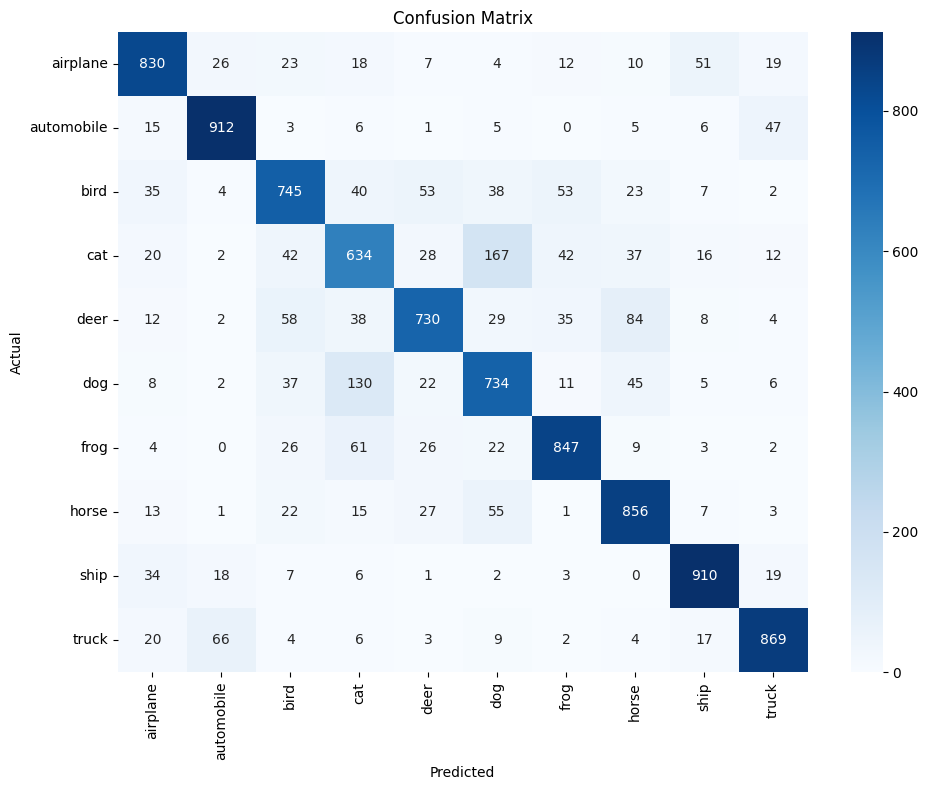


Generating model analysis visualizations...


/tmp/ipykernel_36/4074720813.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


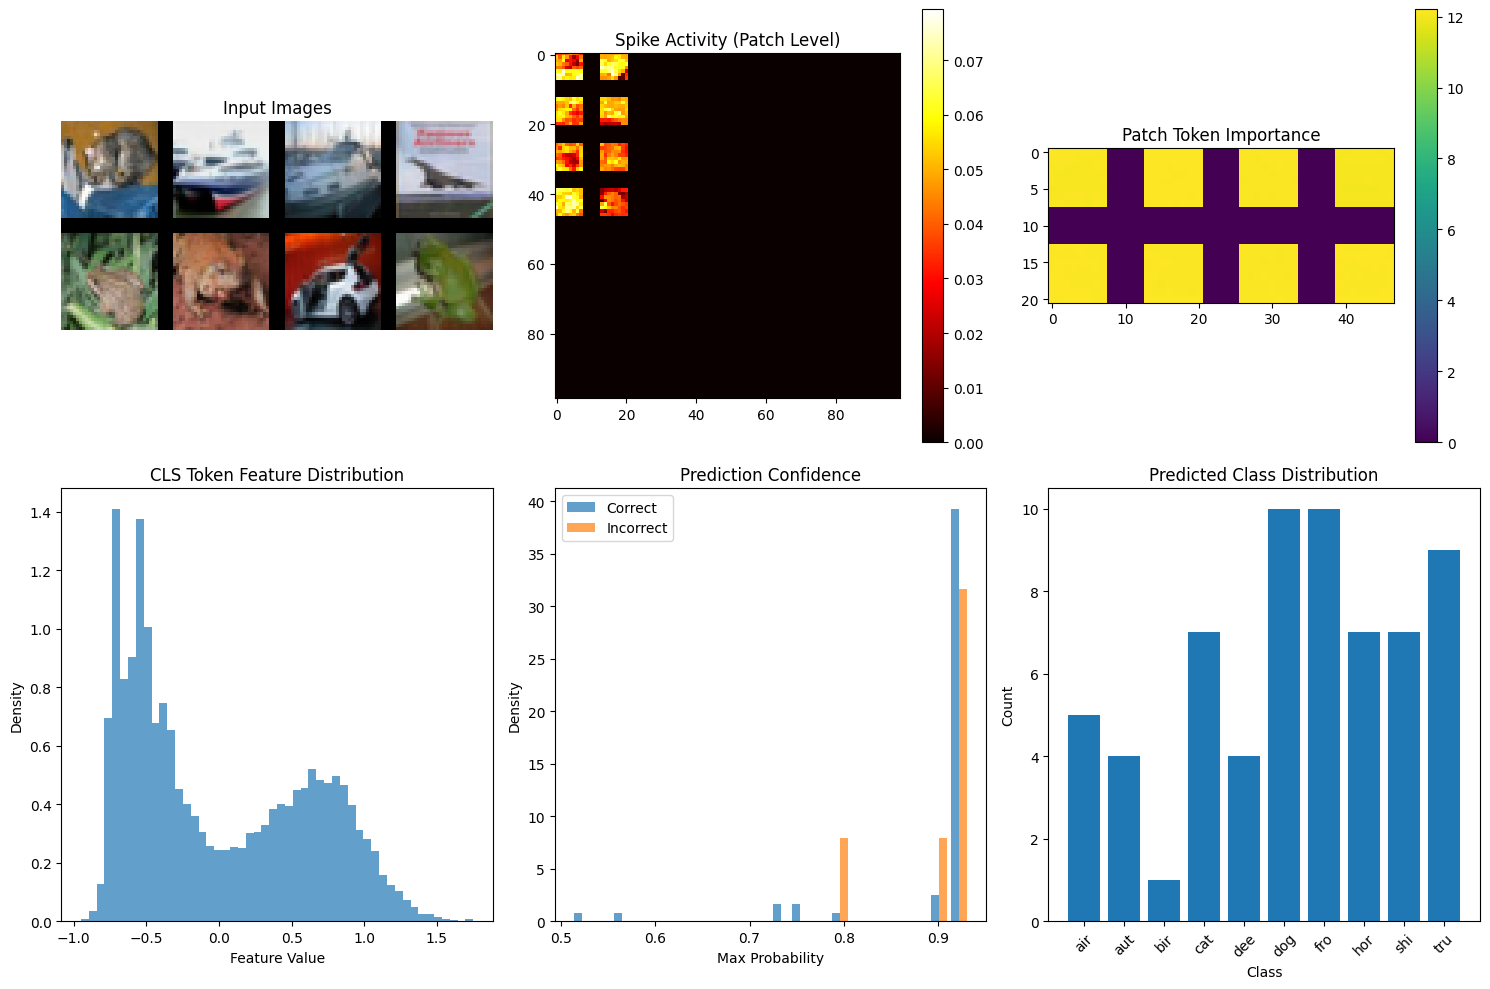

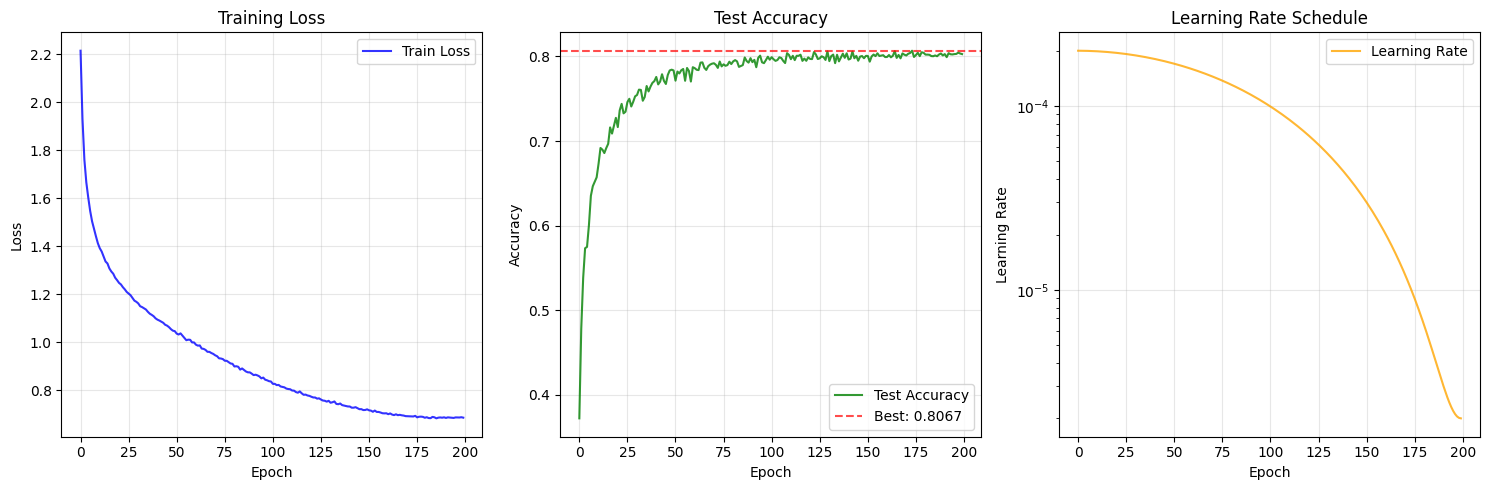


TRAINING SUMMARY
Total Epochs: 200
Best Accuracy: 0.8067
Final Train Loss: 0.6866
Final Test Accuracy: 0.8027
Total Parameters: 11,883,712
Model saved to: ./cifar10_memory_optimized_best.pth

Training completed successfully!
Final Best Accuracy: 0.8067

Running additional analysis...
Testing model inference...
Checkpoint loaded from ./cifar10_memory_optimized_best.pth
Epoch: 174, Best Accuracy: 0.8067
Inference Results (100 samples):
  Average inference time: 14.03 ms
  Accuracy: 0.8900
  Throughput: 71.3 samples/second
Analyzing spiking activity...
Checkpoint loaded from ./cifar10_memory_optimized_best.pth
Epoch: 174, Best Accuracy: 0.8067


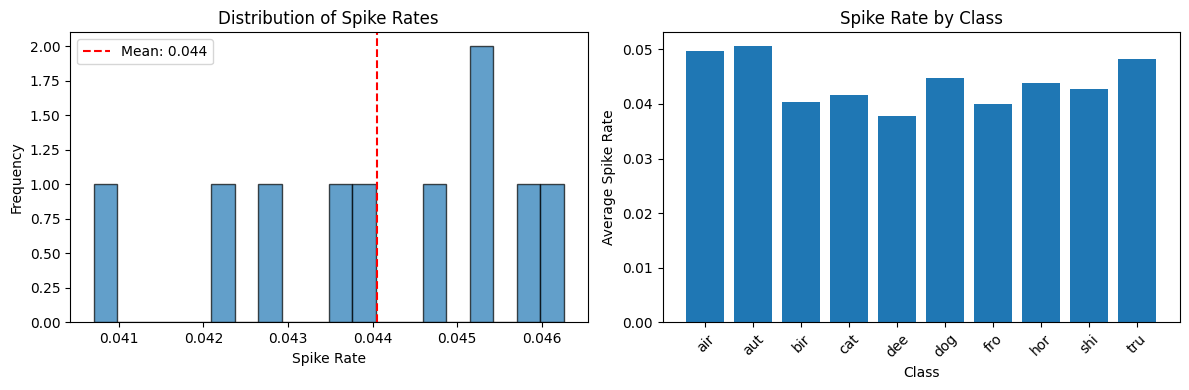

Overall spike statistics:
  Mean spike rate: 0.0440
  Std spike rate: 0.0016
  Min spike rate: 0.0407
  Max spike rate: 0.0463
Memory cleaned up.


In [1]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Memory-Optimized Temporal Spiking ViT for CIFAR-10
----------------------------------------------------
Key optimizations to reduce memory usage:
- Reduced model dimensions
- Gradient checkpointing
- Mixed precision training
- Smaller batch sizes
- Memory-efficient spiking implementation
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_absolute_error, confusion_matrix, roc_curve
import seaborn as sns
import gc

# ================================
# MEMORY-OPTIMIZED HYPERPARAMETERS
# ================================
EMBED_DIM   = 384       # Reduced from 512
NUM_BLOCKS  = 8         # Reduced from 10
NUM_HEADS   = 6         # Reduced from 8
MLP_RATIO   = 3.0       # Reduced from 4.0
PATCH_SIZE  = 4         
T_PATCH     = 4         # Reduced from 8
T_ATTN      = 2         # Reduced from 3
T_MLP       = 2         # Reduced from 3
DROPOUT     = 0.15      
DROPPATH    = 0.15      # Reduced from 0.2
WEIGHT_DECAY= 0.05
LR          = 2e-4      
EPOCHS      = 200       
BATCH_TRAIN = 64        # Reduced from 128
BATCH_TEST  = 128       # Reduced from 256
LABEL_SMOOTH= 0.1       
CLIP_NORM   = 1.0       
WARMUP_EPOCHS = 5       

# Memory optimization flags
USE_GRADIENT_CHECKPOINTING = True
USE_MEMORY_EFFICIENT_ATTENTION = True
ACCUMULATION_STEPS = 2  # Gradient accumulation

COARSE_LOSS_W   = 0.4     
GRAPH_LOSS_W    = 0.15    
KNN_K           = 8       # Reduced from 12
TAU             = 0.07    
BANK_SIZE       = 8192    # Reduced from 16384
GATING_INFER    = True    
EMA_DECAY       = 0.9995  

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    # Memory optimization
    torch.cuda.empty_cache()
    gc.collect()

print(f"Memory-Optimized Spiking ViT for CIFAR-10 initialized on {device}")

# ================================
# Memory-Efficient Spiking Components
# ================================

class MemoryEfficientSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        # Use in-place operation where possible
        out = (x >= 0).to(torch.float32)
        # Save only necessary tensors
        ctx.save_for_backward(x, torch.tensor(temperature))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp.item()
        # Compute gradient efficiently
        sigmoid_x = torch.sigmoid(alpha * x)
        grad = alpha * sigmoid_x * (1 - sigmoid_x)
        return grad_out * grad, None

spike_fn = MemoryEfficientSurrogateSpike.apply

class MemoryEfficientLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        # Memory-efficient implementation
        spike_sum = torch.zeros_like(x)
        mem = torch.zeros_like(x)
        
        # Process timesteps without storing all spikes
        for t in range(T):
            mem = self.decay * mem + x
            mem = torch.clamp(mem, min=-3*self.v_th, max=4*self.v_th)
            s = spike_fn(mem - self.v_th, self.temp_scale)
            mem = mem * (1 - s)
            
            # Weighted accumulation
            weight = (t + 1) / T  # Simple linear weighting
            spike_sum += weight * s
            
        return spike_sum / (T * (T + 1) / 2)  # Normalize by sum of weights

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        return x * mask / keep_prob

# ================================
# Memory-Efficient Patch Embedding
# ================================

class MemoryEfficientPatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.T = T
        
        # Single-stage projection to save memory
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = MemoryEfficientLIFNeuron(decay=0.8, v_th=1.2, learnable=True, temp_scale=0.9)
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        B, C, H, W = feat.shape
        
        # Apply spiking
        spikes = self.lif(feat, T=self.T)
        
        # Convert to tokens
        tokens = spikes.flatten(2).transpose(1, 2)
        
        return tokens, (H, W), spikes

# ================================
# Memory-Efficient Attention
# ================================

class MemoryEfficientAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Compute Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Memory-efficient attention
        if USE_MEMORY_EFFICIENT_ATTENTION and N > 256:
            # Process attention in chunks for large sequences
            attn_out = self._chunked_attention(q, k, v)
        else:
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            attn_out = attn @ v
        
        x = attn_out.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x
    
    def _chunked_attention(self, q, k, v, chunk_size=256):
        B, H, N, D = q.shape
        attn_out = torch.zeros_like(v)
        
        for i in range(0, N, chunk_size):
            end_i = min(i + chunk_size, N)
            q_chunk = q[:, :, i:end_i]
            
            attn_chunk = (q_chunk @ k.transpose(-2, -1)) * self.scale
            attn_chunk = attn_chunk.softmax(dim=-1)
            attn_out[:, :, i:end_i] = attn_chunk @ v
            
        return attn_out

# ================================
# Memory-Efficient Transformer Block
# ================================

class MemoryEfficientTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = MemoryEfficientAttention(embed_dim, num_heads, dropout)
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Simplified MLP to save memory
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
            nn.Dropout(dropout)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Spiking neurons
        self.snn_attn = MemoryEfficientLIFNeuron(decay=0.75, v_th=0.9, learnable=True, temp_scale=1.1)
        self.snn_mlp = MemoryEfficientLIFNeuron(decay=0.8, v_th=1.0, learnable=True, temp_scale=1.0)
        self.T_attn = T_ATTN
        self.T_mlp = T_MLP
        
    def forward(self, x):
        # Attention block
        y = self.norm1(x)
        y = self.attn(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP block
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ================================
# Main Memory-Optimized Model
# ================================

class MemoryOptimizedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.num_classes = num_classes
        self.use_checkpoint = USE_GRADIENT_CHECKPOINTING
        
        self.patch = MemoryEfficientPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        
        # Simple learnable positional embedding
        num_patches = (32 // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            MemoryEfficientTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, dpr[i])
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Simplified heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward_block(self, x, block):
        return block(x)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add CLS token
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embedding
        x = x + self.pos_embed[:, :N+1]
        x = self.pos_drop(x)
        
        # Process blocks with optional checkpointing
        for block in self.blocks:
            if self.use_checkpoint and self.training:
                x = torch.utils.checkpoint.checkpoint(self.forward_block, x, block, use_reentrant=False)
            else:
                x = block(x)
        
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        # Classification
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        if return_aux:
            aux = {
                "conv_spikes": conv_spikes,
                "cls": cls_repr,
                "coarse_logits": coarse_logits,
                "patch_tokens": x[:, 1:]
            }
            return fine_logits, aux
        return fine_logits, None

# ================================
# Training Utilities (Same as before but memory-optimized)
# ================================

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["transportation", "animals", "mixed"]
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

def build_cifar10_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G[2, :] = 0.1
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class MemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = None
        self.probs = None
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        if self.feats is None:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float16)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float16)
        
        feats = F.normalize(feats.detach(), dim=1, p=2).half()
        probs = torch.softmax(logits.detach(), dim=-1).half()
        
        batch_size = feats.size(0)
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if self.__len__() == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size].float()
        active_probs = self.probs[:active_size].float()
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

def get_cifar10_transforms():
    CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
    CIFAR10_STD = [0.2470, 0.2435, 0.2616]
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    return transform_train, transform_test

def train_one_epoch_memory_optimized(model, loader, optimizer, scaler, criterion_fine, 
                                    criterion_coarse, bank, epoch, total_epochs):
    model.train()
    total_loss = 0.0
    accumulated_steps = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        
        with torch.amp.autocast('cuda', enabled=True):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Losses
            ce_fine = criterion_fine(fine_logits, target)
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                spike_rate = conv_spikes.mean()
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 15)
                srl = (spike_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph loss (simplified)
            if bank is not None and bank.__len__() > 0:
                with torch.no_grad():
                    w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU)
                if w is not None:
                    curr_probs = torch.softmax(fine_logits, dim=-1)
                    kl = F.kl_div(curr_probs.log().unsqueeze(1), neigh_probs, reduction='none').sum(dim=-1)
                    g_loss = (w * kl).mean()
                else:
                    g_loss = torch.tensor(0.0, device=device)
            else:
                g_loss = torch.tensor(0.0, device=device)
            
            loss = ce_fine + coarse_weight * ce_coarse + graph_weight * g_loss + srl
            loss = loss / ACCUMULATION_STEPS  # Scale loss for gradient accumulation
        
        scaler.scale(loss).backward()
        accumulated_steps += 1
        
        # Update weights every ACCUMULATION_STEPS
        if accumulated_steps >= ACCUMULATION_STEPS or (batch_idx + 1) == len(loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            accumulated_steps = 0
        
        # Update memory bank
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        total_loss += loss.item() * ACCUMULATION_STEPS
        
        # Clear cache periodically
        if batch_idx % 50 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item() * ACCUMULATION_STEPS:.4f}")
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch}/{total_epochs}] | Avg Loss: {avg_loss:.4f}")
    return avg_loss

@torch.no_grad()
def evaluate_memory_optimized(model, loader, criterion_fine):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        fine_logits, _ = model(data, return_aux=False)
        loss = criterion_fine(fine_logits, target)
        
        pred = fine_logits.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        total_loss += loss.item()
        
    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    
    return accuracy, avg_loss

# ================================
# Detailed Evaluation and Analysis
# ================================

@torch.no_grad()
def detailed_evaluation(model, test_loader):
    """Comprehensive evaluation with metrics and analysis"""
    model.eval()
    
    all_preds = []
    all_targets = []
    all_probs = []
    
    print("Performing detailed evaluation...")
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        fine_logits, aux = model(data, return_aux=True)
        
        probs = torch.softmax(fine_logits, dim=-1)
        preds = fine_logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = (all_preds == all_targets).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    # Per-class accuracy
    class_acc = []
    for i in range(10):
        mask = all_targets == i
        if mask.sum() > 0:
            class_acc.append((all_preds[mask] == i).mean())
        else:
            class_acc.append(0.0)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Display results
    print("\n" + "="*60)
    print("DETAILED EVALUATION RESULTS")
    print("="*60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro Precision:  {precision:.4f}")
    print(f"Macro Recall:     {recall:.4f}")
    print(f"Macro F1-Score:   {f1:.4f}")
    
    print("\nPer-Class Accuracy:")
    for i, (class_name, acc) in enumerate(zip(CIFAR10_CLASSES, class_acc)):
        print(f"  {class_name:12s}: {acc:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_accuracy': class_acc,
        'confusion_matrix': cm
    }

def visualize_model_analysis(model, test_loader):
    """Visualize model behavior and learned features"""
    model.eval()
    
    # Get a batch for visualization
    data_iter = iter(test_loader)
    data, targets = next(data_iter)
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    # Visualize spike activity
    plt.figure(figsize=(15, 10))
    
    # 1. Input images
    plt.subplot(2, 3, 1)
    sample_imgs = data[:8].cpu()
    # Denormalize
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(3, 32*2 + 5, 32*4 + 15)
    for i in range(8):
        row = i // 4
        col = i % 4
        start_h = row * (32 + 5)
        start_w = col * (32 + 5)
        grid[:, start_h:start_h+32, start_w:start_w+32] = sample_imgs[i]
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Input Images')
    plt.axis('off')
    
    # 2. Spike activity heatmap
    plt.subplot(2, 3, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()  # Average over channels
    grid_spikes = torch.zeros(8*8 + 7*5, 8*8 + 7*5)
    
    for i in range(8):
        row = i // 2
        col = i % 2
        if i < len(spike_mean):
            start_h = row * (8 + 5)
            start_w = col * (8 + 5)
            grid_spikes[start_h:start_h+8, start_w:start_w+8] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot')
    plt.title('Spike Activity (Patch Level)')
    plt.colorbar()
    
    # 3. Attention visualization (simplified)
    plt.subplot(2, 3, 3)
    # Use patch token norms as proxy for attention
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    
    grid_attn = torch.zeros(2*8 + 5, 4*8 + 15)
    for i in range(min(8, len(patch_norms))):
        row = i // 4
        col = i % 4
        start_h = row * (8 + 5)
        start_w = col * (8 + 5)
        # Reshape patch norms to 8x8 grid
        patch_grid = patch_norms[i].view(8, 8)
        grid_attn[start_h:start_h+8, start_w:start_w+8] = patch_grid
    
    plt.imshow(grid_attn, cmap='viridis')
    plt.title('Patch Token Importance')
    plt.colorbar()
    
    # 4. Feature distribution
    plt.subplot(2, 3, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Token Feature Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    
    # 5. Prediction confidence
    plt.subplot(2, 3, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence')
    plt.xlabel('Max Probability')
    plt.ylabel('Density')
    plt.legend()
    
    # 6. Class prediction distribution
    plt.subplot(2, 3, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    
    plt.bar(range(10), class_counts)
    plt.title('Predicted Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10), [c[:3] for c in CIFAR10_CLASSES], rotation=45)
    
    plt.tight_layout()
    plt.show()

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath):
    """Save comprehensive model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_accuracy': best_acc,
        'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM,
            'num_blocks': NUM_BLOCKS,
            'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO,
            'patch_size': PATCH_SIZE,
            'dropout': DROPOUT,
            'droppath': DROPPATH,
            'batch_size': BATCH_TRAIN,
            'learning_rate': LR,
            'weight_decay': WEIGHT_DECAY,
        },
        'config': {
            'T_PATCH': T_PATCH,
            'T_ATTN': T_ATTN,
            'T_MLP': T_MLP,
            'use_checkpointing': USE_GRADIENT_CHECKPOINTING,
            'accumulation_steps': ACCUMULATION_STEPS,
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")

def load_model_checkpoint(filepath, model, optimizer=None):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_accuracy']
    
    print(f"Checkpoint loaded from {filepath}")
    print(f"Epoch: {epoch}, Best Accuracy: {best_acc:.4f}")
    
    return epoch, best_acc

# ================================
# Main Training Function (Complete)
# ================================

def main_cifar10_memory_optimized():
    print("Memory-Optimized Temporal Spiking ViT for CIFAR-10")
    print(f"Device: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"GPU Name: {torch.cuda.get_device_properties(0).name}")
    
    print(f"\nOptimized Configuration:")
    print(f"  Embed Dim: {EMBED_DIM} (reduced)")
    print(f"  Blocks: {NUM_BLOCKS} (reduced)")
    print(f"  Heads: {NUM_HEADS} (reduced)")
    print(f"  Batch Size: {BATCH_TRAIN} (reduced)")
    print(f"  Gradient Accumulation: {ACCUMULATION_STEPS} steps")
    print(f"  Gradient Checkpointing: {USE_GRADIENT_CHECKPOINTING}")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True, 
                             pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            pin_memory=True, num_workers=2)
    
    print(f"\nDataset: {len(train_dataset)} train, {len(test_dataset)} test samples")
    
    # Model
    model = MemoryOptimizedSNN_ViT_CIFAR10(
        num_classes=10,
        in_channels=3,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} (trainable: {trainable_params:,})")
    
    # Training setup
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=True)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR * 0.01)
    
    bank = MemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    # Training loop
    best_acc = 0.0
    train_losses = []
    test_accs = []
    learning_rates = []
    
    print("\nStarting Training...")
    print("=" * 60)
    
    for epoch in range(1, EPOCHS + 1):
        # Clear cache at start of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        
        # Train
        train_loss = train_one_epoch_memory_optimized(
            model, train_loader, optimizer, scaler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        train_losses.append(train_loss)
        
        # Evaluate
        test_acc, test_loss = evaluate_memory_optimized(model, test_loader, criterion_fine)
        test_accs.append(test_acc)
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch [{epoch}/{EPOCHS}] | Test Acc: {test_acc:.4f} | Best: {best_acc:.4f} | LR: {current_lr:.2e}")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            save_model_checkpoint(model, optimizer, epoch, best_acc, train_loss, 
                                './cifar10_memory_optimized_best.pth')
            print(f"  → New best model saved! (acc: {best_acc:.4f})")
        
        # Save regular checkpoints
        if epoch % 20 == 0:
            save_model_checkpoint(model, optimizer, epoch, best_acc, train_loss, 
                                f'./cifar10_checkpoint_epoch_{epoch}.pth')
        
        # Early stopping check
        if epoch > 50 and len(test_accs) > 10:
            recent_accs = test_accs[-10:]
            if max(recent_accs) - min(recent_accs) < 0.001:  # Very small improvement
                print(f"Early stopping triggered at epoch {epoch}")
                break
        
        print()
    
    print("=" * 60)
    print(f"Training Complete!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    
    # Final evaluation
    print("\nPerforming detailed evaluation...")
    try:
        # Load best model
        load_model_checkpoint('./cifar10_memory_optimized_best.pth', model)
        
        # Detailed evaluation
        eval_results = detailed_evaluation(model, test_loader)
        
        # Visualize model analysis
        print("\nGenerating model analysis visualizations...")
        visualize_model_analysis(model, test_loader)
        
    except Exception as e:
        print(f"Error during detailed evaluation: {e}")
    
    # Plot training results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(test_accs, label='Test Accuracy', color='green', alpha=0.8)
    plt.axhline(y=best_acc, color='red', linestyle='--', alpha=0.7, label=f'Best: {best_acc:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates, label='Learning Rate', color='orange', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print final summary
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Epochs: {len(train_losses)}")
    print(f"Best Accuracy: {best_acc:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Model saved to: ./cifar10_memory_optimized_best.pth")
    
    return model, best_acc, {
        'train_losses': train_losses,
        'test_accs': test_accs,
        'learning_rates': learning_rates,
        'best_acc': best_acc
    }

# ================================
# Additional Utility Functions
# ================================

def test_model_inference(model_path='./cifar10_memory_optimized_best.pth'):
    """Test model inference speed and accuracy"""
    print("Testing model inference...")
    
    # Load model
    model = MemoryOptimizedSNN_ViT_CIFAR10().to(device)
    load_model_checkpoint(model_path, model)
    model.eval()
    
    # Load test data
    _, transform_test = get_cifar10_transforms()
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Test inference speed
    import time
    
    times = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 100:  # Test first 100 samples
                break
                
            data, target = data.to(device), target.to(device)
            
            start_time = time.time()
            logits, _ = model(data, return_aux=False)
            end_time = time.time()
            
            times.append(end_time - start_time)
            pred = logits.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += 1
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    accuracy = correct / total
    
    print(f"Inference Results (100 samples):")
    print(f"  Average inference time: {avg_time:.2f} ms")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Throughput: {1000/avg_time:.1f} samples/second")

def analyze_spiking_activity(model_path='./cifar10_memory_optimized_best.pth'):
    """Analyze spiking neural activity"""
    print("Analyzing spiking activity...")
    
    model = MemoryOptimizedSNN_ViT_CIFAR10().to(device)
    load_model_checkpoint(model_path, model)
    model.eval()
    
    _, transform_test = get_cifar10_transforms()
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    spike_rates = []
    class_spikes = {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10:  # Analyze first 10 batches
                break
                
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            # Per-class spike analysis
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Spike Rate')
    plt.ylabel('Frequency')
    plt.title('Distribution of Spike Rates')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Class')
    plt.ylabel('Average Spike Rate')
    plt.title('Spike Rate by Class')
    plt.xticks(range(10), [c[:3] for c in CIFAR10_CLASSES], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall spike statistics:")
    print(f"  Mean spike rate: {np.mean(spike_rates):.4f}")
    print(f"  Std spike rate: {np.std(spike_rates):.4f}")
    print(f"  Min spike rate: {np.min(spike_rates):.4f}")
    print(f"  Max spike rate: {np.max(spike_rates):.4f}")

# ================================
# MAIN EXECUTION
# ================================

if __name__ == "__main__":
    # Set up proper error handling
    try:
        # Run main training
        model, best_acc, results = main_cifar10_memory_optimized()
        
        print(f"\nTraining completed successfully!")
        print(f"Final Best Accuracy: {best_acc:.4f}")
        
        # Optional: Run additional analysis
        print("\nRunning additional analysis...")
        test_model_inference()
        analyze_spiking_activity()
        
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("Memory cleaned up.")

Memory-Optimized Spiking ViT for CIFAR-10 initialized on cuda
Memory-Optimized Temporal Spiking ViT for CIFAR-10
Device: cuda
GPU Memory: 17.1 GB
GPU Name: Tesla P100-PCIE-16GB

Optimized Configuration:
  Embed Dim: 384 (reduced)
  Blocks: 8 (reduced)
  Heads: 6 (reduced)
  Batch Size: 64 (reduced)
  Gradient Accumulation: 2 steps
  Gradient Checkpointing: True

Dataset: 50000 train, 10000 test samples
Model parameters: 11,883,712 (trainable: 11,883,712)

Starting Training...


/tmp/ipykernel_36/2901151619.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


  Batch 0/782 | Loss: 2.9189
  Batch 100/782 | Loss: 2.2809
  Batch 200/782 | Loss: 2.2824
  Batch 300/782 | Loss: 2.1194
  Batch 400/782 | Loss: 2.3172
  Batch 500/782 | Loss: 1.9426
  Batch 600/782 | Loss: 2.0530
  Batch 700/782 | Loss: 2.0013
Epoch [1/100] | Avg Loss: 2.2156
Epoch [1/100] | Test Acc: 0.3697 | Best: 0.0000 | LR: 2.00e-04
Checkpoint saved to ./cifar10_memory_optimized_best.pth
  → New best model saved! (acc: 0.3697)

  Batch 0/782 | Loss: 2.0968
  Batch 100/782 | Loss: 2.1619
  Batch 200/782 | Loss: 1.9183
  Batch 300/782 | Loss: 1.9656
  Batch 400/782 | Loss: 1.7538
  Batch 500/782 | Loss: 1.7430
  Batch 600/782 | Loss: 1.9832
  Batch 700/782 | Loss: 1.9504
Epoch [2/100] | Avg Loss: 1.9347
Epoch [2/100] | Test Acc: 0.4813 | Best: 0.3697 | LR: 2.00e-04
Checkpoint saved to ./cifar10_memory_optimized_best.pth
  → New best model saved! (acc: 0.4813)

  Batch 0/782 | Loss: 1.9843
  Batch 100/782 | Loss: 1.7233
  Batch 200/782 | Loss: 1.8171
  Batch 300/782 | Loss: 1.8014


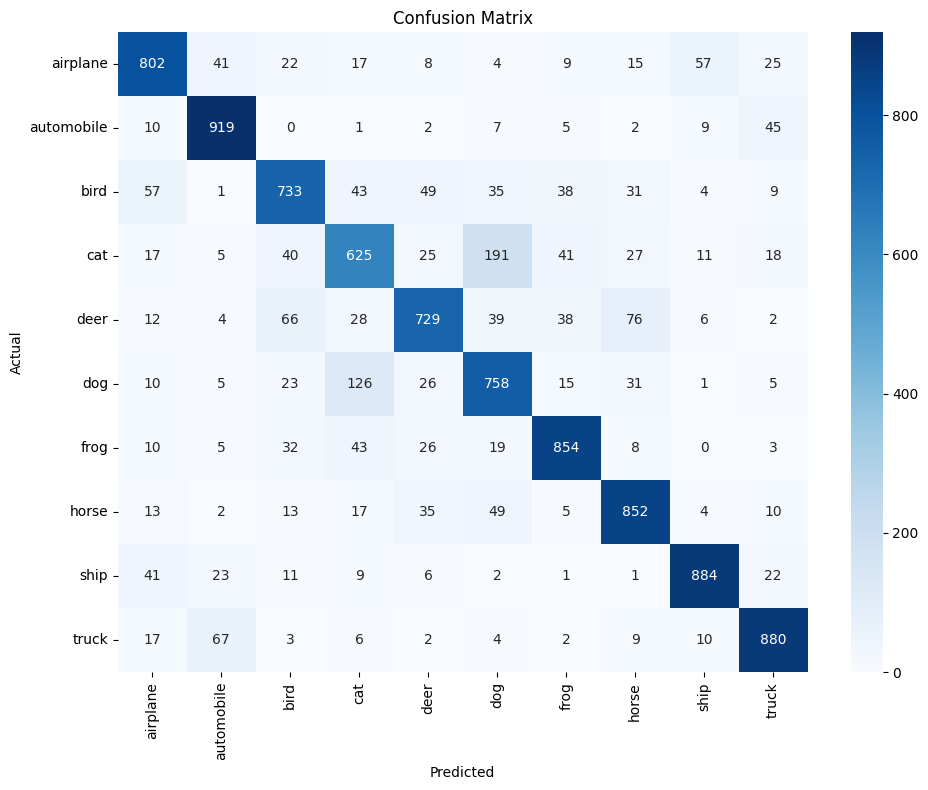


Generating model analysis visualizations...


/tmp/ipykernel_36/2901151619.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


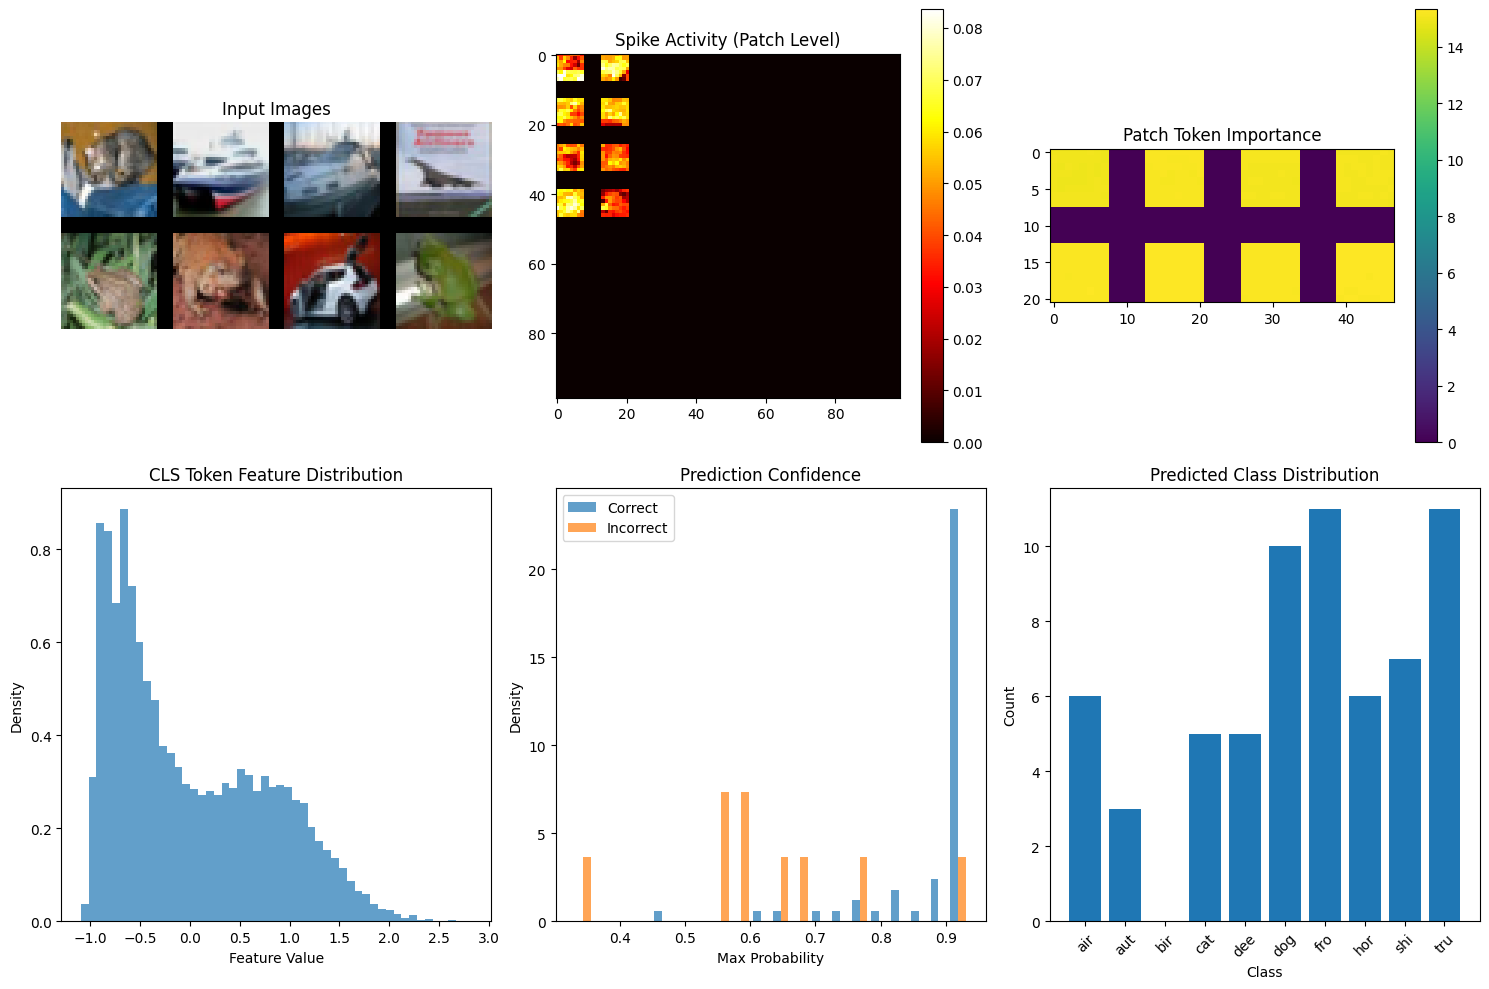

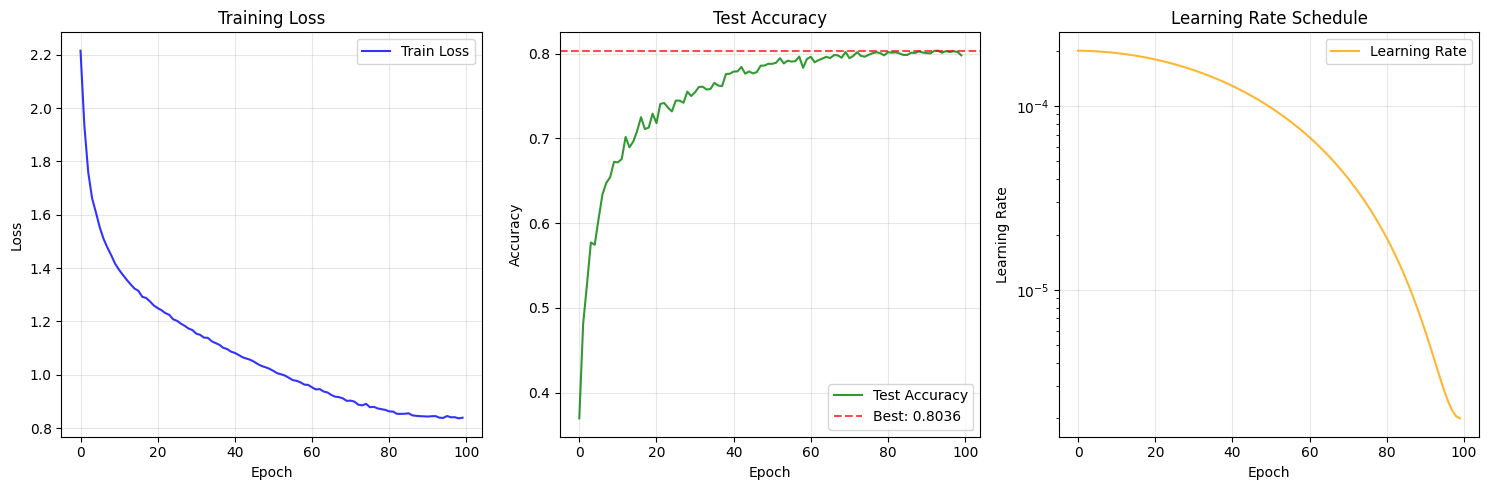


TRAINING SUMMARY
Total Epochs: 100
Best Accuracy: 0.8036
Final Train Loss: 0.8388
Final Test Accuracy: 0.7981
Total Parameters: 11,883,712
Model saved to: ./cifar10_memory_optimized_best.pth

Training completed successfully!
Final Best Accuracy: 0.8036

Running additional analysis...
Testing model inference...
Checkpoint loaded from ./cifar10_memory_optimized_best.pth
Epoch: 94, Best Accuracy: 0.8036
Inference Results (100 samples):
  Average inference time: 13.58 ms
  Accuracy: 0.8300
  Throughput: 73.6 samples/second
Analyzing spiking activity...
Checkpoint loaded from ./cifar10_memory_optimized_best.pth
Epoch: 94, Best Accuracy: 0.8036


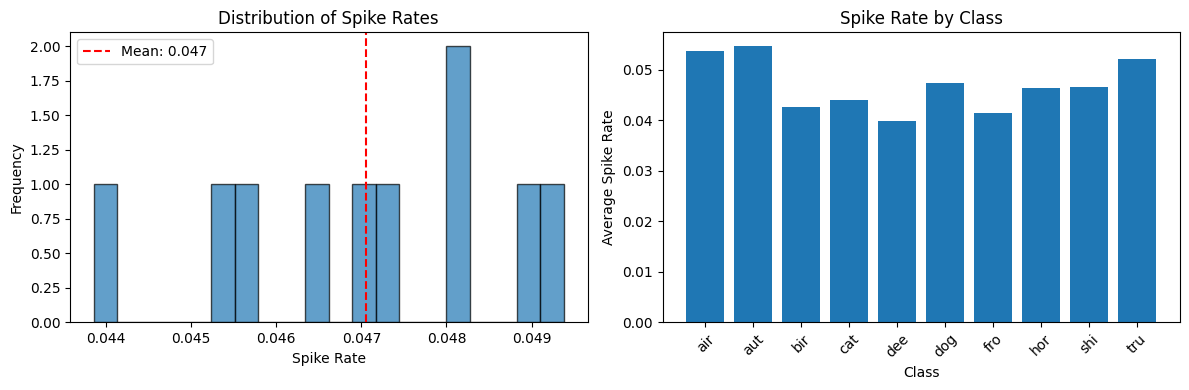

Overall spike statistics:
  Mean spike rate: 0.0471
  Std spike rate: 0.0017
  Min spike rate: 0.0439
  Max spike rate: 0.0494
Memory cleaned up.


In [2]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Memory-Optimized Temporal Spiking ViT for CIFAR-10
----------------------------------------------------
Key optimizations to reduce memory usage:
- Reduced model dimensions
- Gradient checkpointing
- Mixed precision training
- Smaller batch sizes
- Memory-efficient spiking implementation
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_absolute_error, confusion_matrix, roc_curve
import seaborn as sns
import gc

# ================================
# MEMORY-OPTIMIZED HYPERPARAMETERS
# ================================
EMBED_DIM   = 384       # Reduced from 512
NUM_BLOCKS  = 8         # Reduced from 10
NUM_HEADS   = 6         # Reduced from 8
MLP_RATIO   = 3.0       # Reduced from 4.0
PATCH_SIZE  = 4         
T_PATCH     = 4         # Reduced from 8
T_ATTN      = 2         # Reduced from 3
T_MLP       = 2         # Reduced from 3
DROPOUT     = 0.15      
DROPPATH    = 0.15      # Reduced from 0.2
WEIGHT_DECAY= 0.05
LR          = 2e-4      
EPOCHS      = 100       
BATCH_TRAIN = 64        # Reduced from 128
BATCH_TEST  = 128       # Reduced from 256
LABEL_SMOOTH= 0.1       
CLIP_NORM   = 1.0       
WARMUP_EPOCHS = 5       

# Memory optimization flags
USE_GRADIENT_CHECKPOINTING = True
USE_MEMORY_EFFICIENT_ATTENTION = True
ACCUMULATION_STEPS = 2  # Gradient accumulation

COARSE_LOSS_W   = 0.4     
GRAPH_LOSS_W    = 0.15    
KNN_K           = 8       # Reduced from 12
TAU             = 0.07    
BANK_SIZE       = 8192    # Reduced from 16384
GATING_INFER    = True    
EMA_DECAY       = 0.9995  

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    # Memory optimization
    torch.cuda.empty_cache()
    gc.collect()

print(f"Memory-Optimized Spiking ViT for CIFAR-10 initialized on {device}")

# ================================
# Memory-Efficient Spiking Components
# ================================

class MemoryEfficientSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        # Use in-place operation where possible
        out = (x >= 0).to(torch.float32)
        # Save only necessary tensors
        ctx.save_for_backward(x, torch.tensor(temperature))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp.item()
        # Compute gradient efficiently
        sigmoid_x = torch.sigmoid(alpha * x)
        grad = alpha * sigmoid_x * (1 - sigmoid_x)
        return grad_out * grad, None

spike_fn = MemoryEfficientSurrogateSpike.apply

class MemoryEfficientLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        # Memory-efficient implementation
        spike_sum = torch.zeros_like(x)
        mem = torch.zeros_like(x)
        
        # Process timesteps without storing all spikes
        for t in range(T):
            mem = self.decay * mem + x
            mem = torch.clamp(mem, min=-3*self.v_th, max=4*self.v_th)
            s = spike_fn(mem - self.v_th, self.temp_scale)
            mem = mem * (1 - s)
            
            # Weighted accumulation
            weight = (t + 1) / T  # Simple linear weighting
            spike_sum += weight * s
            
        return spike_sum / (T * (T + 1) / 2)  # Normalize by sum of weights

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        return x * mask / keep_prob

# ================================
# Memory-Efficient Patch Embedding
# ================================

class MemoryEfficientPatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.T = T
        
        # Single-stage projection to save memory
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = MemoryEfficientLIFNeuron(decay=0.8, v_th=1.2, learnable=True, temp_scale=0.9)
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        B, C, H, W = feat.shape
        
        # Apply spiking
        spikes = self.lif(feat, T=self.T)
        
        # Convert to tokens
        tokens = spikes.flatten(2).transpose(1, 2)
        
        return tokens, (H, W), spikes

# ================================
# Memory-Efficient Attention
# ================================

class MemoryEfficientAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Compute Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Memory-efficient attention
        if USE_MEMORY_EFFICIENT_ATTENTION and N > 256:
            # Process attention in chunks for large sequences
            attn_out = self._chunked_attention(q, k, v)
        else:
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            attn_out = attn @ v
        
        x = attn_out.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x
    
    def _chunked_attention(self, q, k, v, chunk_size=256):
        B, H, N, D = q.shape
        attn_out = torch.zeros_like(v)
        
        for i in range(0, N, chunk_size):
            end_i = min(i + chunk_size, N)
            q_chunk = q[:, :, i:end_i]
            
            attn_chunk = (q_chunk @ k.transpose(-2, -1)) * self.scale
            attn_chunk = attn_chunk.softmax(dim=-1)
            attn_out[:, :, i:end_i] = attn_chunk @ v
            
        return attn_out

# ================================
# Memory-Efficient Transformer Block
# ================================

class MemoryEfficientTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = MemoryEfficientAttention(embed_dim, num_heads, dropout)
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Simplified MLP to save memory
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
            nn.Dropout(dropout)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Spiking neurons
        self.snn_attn = MemoryEfficientLIFNeuron(decay=0.75, v_th=0.9, learnable=True, temp_scale=1.1)
        self.snn_mlp = MemoryEfficientLIFNeuron(decay=0.8, v_th=1.0, learnable=True, temp_scale=1.0)
        self.T_attn = T_ATTN
        self.T_mlp = T_MLP
        
    def forward(self, x):
        # Attention block
        y = self.norm1(x)
        y = self.attn(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP block
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ================================
# Main Memory-Optimized Model
# ================================

class MemoryOptimizedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.num_classes = num_classes
        self.use_checkpoint = USE_GRADIENT_CHECKPOINTING
        
        self.patch = MemoryEfficientPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        
        # Simple learnable positional embedding
        num_patches = (32 // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            MemoryEfficientTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, dpr[i])
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Simplified heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward_block(self, x, block):
        return block(x)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add CLS token
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embedding
        x = x + self.pos_embed[:, :N+1]
        x = self.pos_drop(x)
        
        # Process blocks with optional checkpointing
        for block in self.blocks:
            if self.use_checkpoint and self.training:
                x = torch.utils.checkpoint.checkpoint(self.forward_block, x, block, use_reentrant=False)
            else:
                x = block(x)
        
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        # Classification
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        if return_aux:
            aux = {
                "conv_spikes": conv_spikes,
                "cls": cls_repr,
                "coarse_logits": coarse_logits,
                "patch_tokens": x[:, 1:]
            }
            return fine_logits, aux
        return fine_logits, None

# ================================
# Training Utilities (Same as before but memory-optimized)
# ================================

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["transportation", "animals", "mixed"]
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

def build_cifar10_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G[2, :] = 0.1
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class MemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = None
        self.probs = None
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        if self.feats is None:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float16)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float16)
        
        feats = F.normalize(feats.detach(), dim=1, p=2).half()
        probs = torch.softmax(logits.detach(), dim=-1).half()
        
        batch_size = feats.size(0)
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if self.__len__() == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size].float()
        active_probs = self.probs[:active_size].float()
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

def get_cifar10_transforms():
    CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
    CIFAR10_STD = [0.2470, 0.2435, 0.2616]
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    return transform_train, transform_test

def train_one_epoch_memory_optimized(model, loader, optimizer, scaler, criterion_fine, 
                                    criterion_coarse, bank, epoch, total_epochs):
    model.train()
    total_loss = 0.0
    accumulated_steps = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        
        with torch.amp.autocast('cuda', enabled=True):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Losses
            ce_fine = criterion_fine(fine_logits, target)
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                spike_rate = conv_spikes.mean()
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 15)
                srl = (spike_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph loss (simplified)
            if bank is not None and bank.__len__() > 0:
                with torch.no_grad():
                    w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU)
                if w is not None:
                    curr_probs = torch.softmax(fine_logits, dim=-1)
                    kl = F.kl_div(curr_probs.log().unsqueeze(1), neigh_probs, reduction='none').sum(dim=-1)
                    g_loss = (w * kl).mean()
                else:
                    g_loss = torch.tensor(0.0, device=device)
            else:
                g_loss = torch.tensor(0.0, device=device)
            
            loss = ce_fine + coarse_weight * ce_coarse + graph_weight * g_loss + srl
            loss = loss / ACCUMULATION_STEPS  # Scale loss for gradient accumulation
        
        scaler.scale(loss).backward()
        accumulated_steps += 1
        
        # Update weights every ACCUMULATION_STEPS
        if accumulated_steps >= ACCUMULATION_STEPS or (batch_idx + 1) == len(loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            accumulated_steps = 0
        
        # Update memory bank
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        total_loss += loss.item() * ACCUMULATION_STEPS
        
        # Clear cache periodically
        if batch_idx % 50 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item() * ACCUMULATION_STEPS:.4f}")
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch}/{total_epochs}] | Avg Loss: {avg_loss:.4f}")
    return avg_loss

@torch.no_grad()
def evaluate_memory_optimized(model, loader, criterion_fine):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        fine_logits, _ = model(data, return_aux=False)
        loss = criterion_fine(fine_logits, target)
        
        pred = fine_logits.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        total_loss += loss.item()
        
    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    
    return accuracy, avg_loss

# ================================
# Detailed Evaluation and Analysis
# ================================

@torch.no_grad()
def detailed_evaluation(model, test_loader):
    """Comprehensive evaluation with metrics and analysis"""
    model.eval()
    
    all_preds = []
    all_targets = []
    all_probs = []
    
    print("Performing detailed evaluation...")
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        fine_logits, aux = model(data, return_aux=True)
        
        probs = torch.softmax(fine_logits, dim=-1)
        preds = fine_logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = (all_preds == all_targets).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    # Per-class accuracy
    class_acc = []
    for i in range(10):
        mask = all_targets == i
        if mask.sum() > 0:
            class_acc.append((all_preds[mask] == i).mean())
        else:
            class_acc.append(0.0)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Display results
    print("\n" + "="*60)
    print("DETAILED EVALUATION RESULTS")
    print("="*60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro Precision:  {precision:.4f}")
    print(f"Macro Recall:     {recall:.4f}")
    print(f"Macro F1-Score:   {f1:.4f}")
    
    print("\nPer-Class Accuracy:")
    for i, (class_name, acc) in enumerate(zip(CIFAR10_CLASSES, class_acc)):
        print(f"  {class_name:12s}: {acc:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_accuracy': class_acc,
        'confusion_matrix': cm
    }

def visualize_model_analysis(model, test_loader):
    """Visualize model behavior and learned features"""
    model.eval()
    
    # Get a batch for visualization
    data_iter = iter(test_loader)
    data, targets = next(data_iter)
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    # Visualize spike activity
    plt.figure(figsize=(15, 10))
    
    # 1. Input images
    plt.subplot(2, 3, 1)
    sample_imgs = data[:8].cpu()
    # Denormalize
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(3, 32*2 + 5, 32*4 + 15)
    for i in range(8):
        row = i // 4
        col = i % 4
        start_h = row * (32 + 5)
        start_w = col * (32 + 5)
        grid[:, start_h:start_h+32, start_w:start_w+32] = sample_imgs[i]
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Input Images')
    plt.axis('off')
    
    # 2. Spike activity heatmap
    plt.subplot(2, 3, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()  # Average over channels
    grid_spikes = torch.zeros(8*8 + 7*5, 8*8 + 7*5)
    
    for i in range(8):
        row = i // 2
        col = i % 2
        if i < len(spike_mean):
            start_h = row * (8 + 5)
            start_w = col * (8 + 5)
            grid_spikes[start_h:start_h+8, start_w:start_w+8] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot')
    plt.title('Spike Activity (Patch Level)')
    plt.colorbar()
    
    # 3. Attention visualization (simplified)
    plt.subplot(2, 3, 3)
    # Use patch token norms as proxy for attention
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    
    grid_attn = torch.zeros(2*8 + 5, 4*8 + 15)
    for i in range(min(8, len(patch_norms))):
        row = i // 4
        col = i % 4
        start_h = row * (8 + 5)
        start_w = col * (8 + 5)
        # Reshape patch norms to 8x8 grid
        patch_grid = patch_norms[i].view(8, 8)
        grid_attn[start_h:start_h+8, start_w:start_w+8] = patch_grid
    
    plt.imshow(grid_attn, cmap='viridis')
    plt.title('Patch Token Importance')
    plt.colorbar()
    
    # 4. Feature distribution
    plt.subplot(2, 3, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Token Feature Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    
    # 5. Prediction confidence
    plt.subplot(2, 3, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence')
    plt.xlabel('Max Probability')
    plt.ylabel('Density')
    plt.legend()
    
    # 6. Class prediction distribution
    plt.subplot(2, 3, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    
    plt.bar(range(10), class_counts)
    plt.title('Predicted Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10), [c[:3] for c in CIFAR10_CLASSES], rotation=45)
    
    plt.tight_layout()
    plt.show()

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath):
    """Save comprehensive model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_accuracy': best_acc,
        'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM,
            'num_blocks': NUM_BLOCKS,
            'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO,
            'patch_size': PATCH_SIZE,
            'dropout': DROPOUT,
            'droppath': DROPPATH,
            'batch_size': BATCH_TRAIN,
            'learning_rate': LR,
            'weight_decay': WEIGHT_DECAY,
        },
        'config': {
            'T_PATCH': T_PATCH,
            'T_ATTN': T_ATTN,
            'T_MLP': T_MLP,
            'use_checkpointing': USE_GRADIENT_CHECKPOINTING,
            'accumulation_steps': ACCUMULATION_STEPS,
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")

def load_model_checkpoint(filepath, model, optimizer=None):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_accuracy']
    
    print(f"Checkpoint loaded from {filepath}")
    print(f"Epoch: {epoch}, Best Accuracy: {best_acc:.4f}")
    
    return epoch, best_acc

# ================================
# Main Training Function (Complete)
# ================================

def main_cifar10_memory_optimized():
    print("Memory-Optimized Temporal Spiking ViT for CIFAR-10")
    print(f"Device: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"GPU Name: {torch.cuda.get_device_properties(0).name}")
    
    print(f"\nOptimized Configuration:")
    print(f"  Embed Dim: {EMBED_DIM} (reduced)")
    print(f"  Blocks: {NUM_BLOCKS} (reduced)")
    print(f"  Heads: {NUM_HEADS} (reduced)")
    print(f"  Batch Size: {BATCH_TRAIN} (reduced)")
    print(f"  Gradient Accumulation: {ACCUMULATION_STEPS} steps")
    print(f"  Gradient Checkpointing: {USE_GRADIENT_CHECKPOINTING}")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True, 
                             pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            pin_memory=True, num_workers=2)
    
    print(f"\nDataset: {len(train_dataset)} train, {len(test_dataset)} test samples")
    
    # Model
    model = MemoryOptimizedSNN_ViT_CIFAR10(
        num_classes=10,
        in_channels=3,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} (trainable: {trainable_params:,})")
    
    # Training setup
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=True)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR * 0.01)
    
    bank = MemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    # Training loop
    best_acc = 0.0
    train_losses = []
    test_accs = []
    learning_rates = []
    
    print("\nStarting Training...")
    print("=" * 60)
    
    for epoch in range(1, EPOCHS + 1):
        # Clear cache at start of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        
        # Train
        train_loss = train_one_epoch_memory_optimized(
            model, train_loader, optimizer, scaler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        train_losses.append(train_loss)
        
        # Evaluate
        test_acc, test_loss = evaluate_memory_optimized(model, test_loader, criterion_fine)
        test_accs.append(test_acc)
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch [{epoch}/{EPOCHS}] | Test Acc: {test_acc:.4f} | Best: {best_acc:.4f} | LR: {current_lr:.2e}")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            save_model_checkpoint(model, optimizer, epoch, best_acc, train_loss, 
                                './cifar10_memory_optimized_best.pth')
            print(f"  → New best model saved! (acc: {best_acc:.4f})")
        
        # Save regular checkpoints
        if epoch % 20 == 0:
            save_model_checkpoint(model, optimizer, epoch, best_acc, train_loss, 
                                f'./cifar10_checkpoint_epoch_{epoch}.pth')
        
        # Early stopping check
        if epoch > 50 and len(test_accs) > 10:
            recent_accs = test_accs[-10:]
            if max(recent_accs) - min(recent_accs) < 0.001:  # Very small improvement
                print(f"Early stopping triggered at epoch {epoch}")
                break
        
        print()
    
    print("=" * 60)
    print(f"Training Complete!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    
    # Final evaluation
    print("\nPerforming detailed evaluation...")
    try:
        # Load best model
        load_model_checkpoint('./cifar10_memory_optimized_best.pth', model)
        
        # Detailed evaluation
        eval_results = detailed_evaluation(model, test_loader)
        
        # Visualize model analysis
        print("\nGenerating model analysis visualizations...")
        visualize_model_analysis(model, test_loader)
        
    except Exception as e:
        print(f"Error during detailed evaluation: {e}")
    
    # Plot training results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(test_accs, label='Test Accuracy', color='green', alpha=0.8)
    plt.axhline(y=best_acc, color='red', linestyle='--', alpha=0.7, label=f'Best: {best_acc:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates, label='Learning Rate', color='orange', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print final summary
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Epochs: {len(train_losses)}")
    print(f"Best Accuracy: {best_acc:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Model saved to: ./cifar10_memory_optimized_best.pth")
    
    return model, best_acc, {
        'train_losses': train_losses,
        'test_accs': test_accs,
        'learning_rates': learning_rates,
        'best_acc': best_acc
    }

# ================================
# Additional Utility Functions
# ================================

def test_model_inference(model_path='./cifar10_memory_optimized_best.pth'):
    """Test model inference speed and accuracy"""
    print("Testing model inference...")
    
    # Load model
    model = MemoryOptimizedSNN_ViT_CIFAR10().to(device)
    load_model_checkpoint(model_path, model)
    model.eval()
    
    # Load test data
    _, transform_test = get_cifar10_transforms()
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Test inference speed
    import time
    
    times = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 100:  # Test first 100 samples
                break
                
            data, target = data.to(device), target.to(device)
            
            start_time = time.time()
            logits, _ = model(data, return_aux=False)
            end_time = time.time()
            
            times.append(end_time - start_time)
            pred = logits.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += 1
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    accuracy = correct / total
    
    print(f"Inference Results (100 samples):")
    print(f"  Average inference time: {avg_time:.2f} ms")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Throughput: {1000/avg_time:.1f} samples/second")

def analyze_spiking_activity(model_path='./cifar10_memory_optimized_best.pth'):
    """Analyze spiking neural activity"""
    print("Analyzing spiking activity...")
    
    model = MemoryOptimizedSNN_ViT_CIFAR10().to(device)
    load_model_checkpoint(model_path, model)
    model.eval()
    
    _, transform_test = get_cifar10_transforms()
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    spike_rates = []
    class_spikes = {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10:  # Analyze first 10 batches
                break
                
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            # Per-class spike analysis
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Spike Rate')
    plt.ylabel('Frequency')
    plt.title('Distribution of Spike Rates')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Class')
    plt.ylabel('Average Spike Rate')
    plt.title('Spike Rate by Class')
    plt.xticks(range(10), [c[:3] for c in CIFAR10_CLASSES], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall spike statistics:")
    print(f"  Mean spike rate: {np.mean(spike_rates):.4f}")
    print(f"  Std spike rate: {np.std(spike_rates):.4f}")
    print(f"  Min spike rate: {np.min(spike_rates):.4f}")
    print(f"  Max spike rate: {np.max(spike_rates):.4f}")

# ================================
# MAIN EXECUTION
# ================================

if __name__ == "__main__":
    # Set up proper error handling
    try:
        # Run main training
        model, best_acc, results = main_cifar10_memory_optimized()
        
        print(f"\nTraining completed successfully!")
        print(f"Final Best Accuracy: {best_acc:.4f}")
        
        # Optional: Run additional analysis
        print("\nRunning additional analysis...")
        test_model_inference()
        analyze_spiking_activity()
        
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("Memory cleaned up.")